In [1]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


# Introduction

[Deployed App Link](https://huggingface.co/spaces/galuhalifani/student_dropout_prediction)

================================================

Milestone 2

Nama  : Galuh Adika Alifani\
Batch : RMT-040

This report is made as part of machine learning model creation on student dropout prediction, in order to help academic staff better identify high-risk students and offer supportive intervention.

Sections in this report:
1. Introduction
2. Data Loading
3. Data Analysis
4. Feature Engineering
5. Model Training
6. Model Evaluation
7. Model Saving

=================================================

## Problem Identification

Academic success plays a crucial role in shaping an individual’s future, influencing career opportunities, financial stability, and overall well-being. However, many students face challenges that may lead to poor academic performance or even dropping out. Early identification of students at risk of academic failure or dropout is essential to provide timely interventions and support. Hence, this project aims to develop a predictive model that determines whether a student is likely to drop out based on certain contributing factors.

## Objective

The objective is to create a predictive model and a corresponding web-app to identify whether a student is likely to drop-out, so that the the school can offer early intervention strategies to those at risk of dropping out, such as study resources, mentorship programs, or psychological support, to improve their chances of success. We aim mainly to evalue the recall rate of the model, and predict at least 80% drop-out students correctly.

The model and app should mainly be used for school academic department, teachers and academic counselors to identify students needing additional support and refine academic programs to boost students' performances.

## Data Information

*Data Source: [Students' Enrollment Status](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)*

**Dataset Description**

> This dataset contains 4,000 records of students from a higher education institution of students enrolled in different undergraduate degrees.

**Content**

> The data includes information known at the time of student's enrollment: education background, family & financial background, and macroeconomic conditions; students' academic performance at the end of the first and second semesters; as well as students' enrollment status at the point of the data collection time.

# Import Libraries

In [103]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import json
from sklearn.metrics import classification_report, recall_score, f1_score
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import recall_score

try:
  import dill
except:
  %pip install dill
finally:
  import dill
  
try:
  from catboost import CatBoostClassifier
except:
  %pip install catboost
finally:
  from catboost import CatBoostClassifier

try:
  from feature_engine.outliers import Winsorizer
except:
    %pip install feature_engine
finally:
    from feature_engine.outliers import Winsorizer

try:
  import phik
except:
  %pip install phik
finally:
  import phik

try:
  import tabulate
except:
  %pip install tabulate
finally:
  import tabulate

try:
  from ucimlrepo import fetch_ucirepo
except:
  %pip install ucimlrepo
finally:
  from ucimlrepo import fetch_ucirepo

# Data Loading

In [ ]:
# fetch dataset
student_enrollment_data = fetch_ucirepo(id=697)

# data (as pandas dataframes)
raw_data = student_enrollment_data.data.original

# save data for backup
raw_data.to_csv("./data/student_enrollment_data_raw.csv", index=False)

### General Overview

In [105]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

*   The data has 36 columns and 4.4k records. Each record represent one student.
*   We can see that all the column type appears to be numerical, however, based on the [variables table](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) description of the data source, we know that some of these variables are actually categorical variables that have been encoded. For the purpose of building the model, this is beneficial for us, but for the purpose of EDA and generating better overall insights, we would want to un-encode these columns, especially for the ones with high cardinality
*   Some of the column name is too long to be properly used for analysis or data processing. We might want to rename them so it's easier to manage during preprocessing
*   The definition of `Curricular units` variables might be rather confusing. After looking at the original dataset's definition of the variables, here is an interpreted definition of the variables:
> Credited = Number of courses where credits have already been earned\
> Enrolled = Number of courses the student is currently registered in\
> Evaluated = Number of courses where the student has already taken at least one exam\
> Approved = Number of courses already passed (but not yet credited)
*   We can also see that the grades scale are from 0 - 20. For better interpretation and easier understanding, we can scale back this score to international scoring system of 0-100
*   Macroeconomics indicator like GDP has also been scaled, which may pose difficult for us in interpreting the values and correlation

Next Steps:
- Data clean-up:
  - Duplicate check
  - Missing value check
- Pre-processing & manipulation:
  - Column renaming
  - Un-encode categorical columns
  - Convert grades to international scoring
- Others:
  - Define cat vs. num cols



### Duplicate Check

In [106]:
#check duplicates
print('Total Duplicated Records:', raw_data.duplicated().sum())

Total Duplicated Records: 0


### Missing Value Overview

In [107]:
#check missing values
print(f'total missing values: {raw_data.isna().sum().sum()}\n')

total missing values: 0



### Rename Columns

In [108]:
old_columns_names = raw_data.columns
new_column_names = [
    "marital_status",
    "application_mode",
    "application_order",
    "course",
    "course_time",
    "education_level",
    "previous_grade",
    "nationality",
    "mother_education",
    "father_education",
    "mother_occupation",
    "father_occupation",
    "admission_grade",
    "is_displaced",
    "has_special_needs",
    "is_debtor",
    "is_tuition_paid",
    "gender",
    "is_scholarship_holder",
    "age_at_enrollment",
    "is_international",
    "s1_credited",
    "s1_enrolled",
    "s1_evaluated",
    "s1_approved",
    "s1_grade",
    "s1_not_evaluated",
    "s2_credited",
    "s2_enrolled",
    "s2_evaluated",
    "s2_approved",
    "s2_grade",
    "s2_not_evaluated",
    "unemployment_rate",
    "inflation_rate",
    "gdp",
    "status"
]

col_rename_mapping = dict(zip(old_columns_names, new_column_names))

df_renamed = raw_data.rename(columns=col_rename_mapping)
df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   marital_status         4424 non-null   int64  
 1   application_mode       4424 non-null   int64  
 2   application_order      4424 non-null   int64  
 3   course                 4424 non-null   int64  
 4   course_time            4424 non-null   int64  
 5   education_level        4424 non-null   int64  
 6   previous_grade         4424 non-null   float64
 7   nationality            4424 non-null   int64  
 8   mother_education       4424 non-null   int64  
 9   father_education       4424 non-null   int64  
 10  mother_occupation      4424 non-null   int64  
 11  father_occupation      4424 non-null   int64  
 12  admission_grade        4424 non-null   float64
 13  is_displaced           4424 non-null   int64  
 14  has_special_needs      4424 non-null   int64  
 15  is_d

### Un-Encode Data

As mentioned before, for the purpose of EDA and understanding insights from our data better, we would want to un-encode these columns, *except* for binary-value columns

In [109]:
# Dictionary for all categorical (non-binary) variables. Note that some of the values has been paraphrased for simplicity

gender_dict = {
    0: "female",
    1: "male"
}

marital_status_dict = {
    1: "single",
    2: "married",
    3: "widower",
    4: "divorced",
    5: "facto union",
    6: "legally separated"
}

course_time_dict = {
    0: "evening",
    1: "daytime"
}

application_mode_dict = {
    1: "1st phase - general contingent",
    2: "Ordinance No. 612/93",
    5: "1st phase - special contingent (Azores Island)",
    7: "Holders of other higher courses",
    10: "Ordinance No. 854-B/99",
    15: "International student (bachelor)",
    16: "1st phase - special contingent (Madeira Island)",
    17: "2nd phase - general contingent",
    18: "3rd phase - general contingent",
    26: "Ordinance No. 533-A/99, item b2) (Different Plan)",
    27: "Ordinance No. 533-A/99, item b3 (Other Institution)",
    39: "Over 23 years old",
    42: "Transfer",
    43: "Change of course",
    44: "Technological specialization diploma holders",
    51: "Change of institution/course",
    53: "Short cycle diploma holders",
    57: "Change of institution/course (International)"
}

course_dict = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
}

nationality_dict = {
    1: "Portuguese", 2: "German", 6: "Spanish", 11: "Italian",
    13: "Dutch", 14: "English", 17: "Lithuanian", 21: "Angolan",
    22: "Cape Verdean", 24: "Guinean", 25: "Mozambican", 26: "Santomean",
    32: "Turkish", 41: "Brazilian", 62: "Romanian", 100: "Moldova (Republic of)",
    101: "Mexican", 103: "Ukrainian", 105: "Russian", 108: "Cuban",
    109: "Colombian"
}

education_qualification_dict = {
    1: "Secondary",
    2: "Bachelors degree",
    3: "Higher education (diploma)",
    4: "Masters degree",
    5: "Doctorate degree",
    6: "Higher education (diploma)",
    9: "12th grade - not completed",
    10: "11th grade - not completed",
    11: "7th grade",
    12: "11th-grade",
    13: "2nd-year complementary high school",
    14: "10th grade",
    15: "10th grade - not completed",
    18: "General commerce course",
    19: "Basic 3rd cycle (9th-11th)",
    20: "Complementary high school",
    22: "Technical/professional course",
    25: "Incomplete high school",
    26: "7th grade",
    27: "Basic 2nd cycle (6th-8th)",
    29: "9th grade - not completed",
    30: "8th grade",
    31: "Administration & commerce course",
    33: "Supplementary accounting & admin",
    34: "Unknown",
    35: "Illiterate",
    36: "Can read, no formal schooling",
    37: "Basic 1st cycle (4th-5th)",
    38: "Basic 2nd cycle (6th-8th)",
    39: "Technological specialization",
    40: "Higher education (diploma)",
    41: "Specialized higher studies",
    42: "Professional higher technical course",
    43: "Masters degree",
    44: "Doctorate degree"
}

parent_occupation_dict = {
    0: "Student",
    1: "Govt & executive leaders",
    2: "Specialists (science, law, etc.)",
    3: "Technicians & associate professionals",
    4: "Admin staff",
    5: "Personal services & sales",
    6: "Farmers & agriculture",
    7: "Skilled industry workers",
    8: "Machine operators",
    9: "Unskilled workers",
    10: "Military professions",
    90: "Other",
    99: "Other",
    101: "Military officers",
    102: "Military sergeants",
    103: "Military professions",
    112: "Admin & commercial managers",
    114: "Hotel & service managers",
    121: "Scientists & engineers",
    122: "Healthcare professionals",
    123: "Teachers",
    124: "Finance & admin specialists",
    131: "Science & engineering technicians",
    132: "Health technicians",
    134: "Legal, sports & culture techs",
    135: "IT technicians",
    141: "Secretaries & office workers",
    143: "Accounting & financial clerks",
    144: "Other admin support",
    151: "Personal service workers",
    152: "Sellers",
    153: "Care & welfare workers",
    154: "Security & protection services",
    161: "Commercial farmers",
    163: "Subsistence farmers & fishermen",
    171: "Construction workers (non-electricians)",
    172: "Metalworkers",
    174: "Electricians & electronics workers",
    175: "Food, textile, & wood industry workers",
    181: "Machine operators",
    182: "Assembly workers",
    183: "Drivers & transport operators",
    192: "Unskilled farm & fishery workers",
    193: "Unskilled industry & transport workers",
    194: "Kitchen assistants",
    195: "Street vendors (non-food)"
}


In [110]:
# create dataset copy
df = df_renamed.copy()

# un-encode
df["gender"] = df["gender"].replace(gender_dict)
df["marital_status"] = df["marital_status"].replace(marital_status_dict)
df["course_time"] = df["course_time"].replace(course_time_dict)
df["application_mode"] = df["application_mode"].replace(application_mode_dict)
df["course"] = df["course"].replace(course_dict)
df["nationality"] = df["nationality"].replace(nationality_dict)
df["education_level"] = df["education_level"].replace(education_qualification_dict)
df["mother_education"] = df["mother_education"].replace(education_qualification_dict)
df["father_education"] = df["father_education"].replace(education_qualification_dict)
df["mother_occupation"] = df["mother_occupation"].replace(parent_occupation_dict)
df["father_occupation"] = df["father_occupation"].replace(parent_occupation_dict)

df.head()

,marital_status,application_mode,application_order,course,course_time,education_level,previous_grade,nationality,mother_education,father_education,...,s2_credited,s2_enrolled,s2_evaluated,s2_approved,s2_grade,s2_not_evaluated,unemployment_rate,inflation_rate,gdp,status
0,single,2nd phase - general contingent,5,Animation and Multimedia Design,daytime,Secondary,122.0,Portuguese,Basic 3rd cycle (9th-11th),11th-grade,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,single,International student (bachelor),1,Tourism,daytime,Secondary,160.0,Portuguese,Secondary,Higher education (diploma),...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,single,1st phase - general contingent,5,Communication Design,daytime,Secondary,122.0,Portuguese,Basic 1st cycle (4th-5th),Basic 1st cycle (4th-5th),...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,single,2nd phase - general contingent,2,Journalism and Communication,daytime,Secondary,122.0,Portuguese,Basic 2nd cycle (6th-8th),Basic 1st cycle (4th-5th),...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary,100.0,Portuguese,Basic 1st cycle (4th-5th),Basic 2nd cycle (6th-8th),...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Convert Grading

In [111]:
df['s1_grade'] = df['s1_grade'] / 20 * 100
df['s2_grade'] = df['s2_grade'] / 20 * 100
df['admission_grade'] = df['admission_grade'] / 200 * 100
df['previous_grade'] = df['previous_grade'] / 200 * 100
df.head()

,marital_status,application_mode,application_order,course,course_time,education_level,previous_grade,nationality,mother_education,father_education,...,s2_credited,s2_enrolled,s2_evaluated,s2_approved,s2_grade,s2_not_evaluated,unemployment_rate,inflation_rate,gdp,status
0,single,2nd phase - general contingent,5,Animation and Multimedia Design,daytime,Secondary,61.0,Portuguese,Basic 3rd cycle (9th-11th),11th-grade,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,single,International student (bachelor),1,Tourism,daytime,Secondary,80.0,Portuguese,Secondary,Higher education (diploma),...,0,6,6,6,68.333333,0,13.9,-0.3,0.79,Graduate
2,single,1st phase - general contingent,5,Communication Design,daytime,Secondary,61.0,Portuguese,Basic 1st cycle (4th-5th),Basic 1st cycle (4th-5th),...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,single,2nd phase - general contingent,2,Journalism and Communication,daytime,Secondary,61.0,Portuguese,Basic 2nd cycle (6th-8th),Basic 1st cycle (4th-5th),...,0,6,10,5,62.000000,0,9.4,-0.8,-3.12,Graduate
4,married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary,50.0,Portuguese,Basic 1st cycle (4th-5th),Basic 2nd cycle (6th-8th),...,0,6,6,6,65.000000,0,13.9,-0.3,0.79,Graduate


### Split cat vs num cols

In [112]:
categorical_columns = df.select_dtypes(include=['object']).columns
binary_columns = ['is_displaced', 'has_special_needs', 'is_debtor', 'is_tuition_paid', 'is_scholarship_holder', 'is_international']
numerical_columns = [col for col in df.columns if col not in categorical_columns and col not in binary_columns]

column_type_summary = {
    "categorical": categorical_columns,
    "binary": binary_columns,
    "numerical": numerical_columns
}

column_summary_df = pd.DataFrame.from_dict(column_type_summary, orient='index').transpose()
column_summary_df.fillna("-", inplace=True)
column_summary_df

,categorical,binary,numerical
0,marital_status,is_displaced,application_order
1,application_mode,has_special_needs,previous_grade
2,course,is_debtor,admission_grade
3,course_time,is_tuition_paid,age_at_enrollment
4,education_level,is_scholarship_holder,s1_credited
5,nationality,is_international,s1_enrolled
6,mother_education,-,s1_evaluated
7,father_education,-,s1_approved
8,mother_occupation,-,s1_grade
9,father_occupation,-,s1_not_evaluated


# Exploratory Data Analysis (EDA)

For initial EDA purpose, we can explore the data and generate a few insights by answering several interesting questions from basic to complex, such as:

1. Demographics overview of the students (at point of enrollment)
   - Age: how is the age distribution of the dataset?
   - Gender: are male and female equally represented?
   - Marital status: are most of the students single or married?
   - International students composition: how many students come from outside of the country?

2. Average student academic & financial performance at the time of data collection
   - Student status (Graduate, Dropout, Enrolled): How many students are graduated, dropped-out, versus still enrolled?
   - Average grade of both semesters: what are the average grade of semester 1 and 2?
   - Tuition payment status: how is the tuition payment status like for most students?
   - Scholarship holders composition: how many students are scholarship holders?
   - Top 10 course subjects: what are the top 10 course subjects?

3. Do dropout students tend to have lower semester grades?

4. How does admission grade impact student success (dropout vs. graduation)?

5. Is there a correlation between admission_grade and average semester grade?

6. Do economic data (unemployment rate, inflation, GDP) impact student dropout rates?

7. Do family background factors (parents' education and occupation) impact student dropout rates?

In [113]:
# copy dataset for analysis
dfa = df.copy()

In [114]:
def distribution_histplot(chart_num, data1, data2, variable1, variable2, widthSize, heightSize, bins, title1, title2, kde=False):
    '''
    function to plot distribution figures
    '''
    plt.figure(figsize=(widthSize, heightSize))

    plt.subplot(1, 2, 1)
    sns.histplot(data1[variable1], bins=bins, kde=kde)
    plt.title(title1)

    if chart_num == 2:
        plt.subplot(1, 2, 2)
        sns.histplot(data2[variable2], bins=bins, kde=kde)
        plt.title(title2)

    plt.show()

#### Demographic Overview

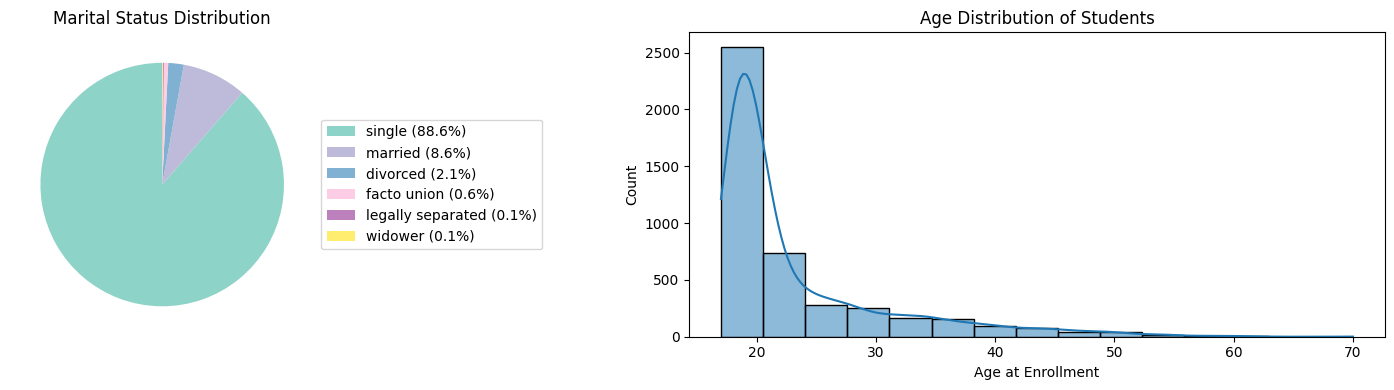

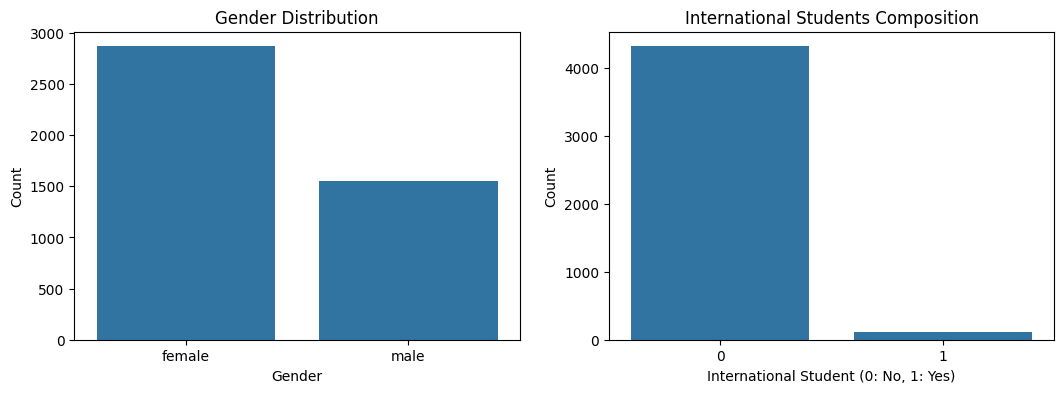

In [115]:
# Set figure size for better readability
plt.figure(figsize=(16, 4))

# 1. Age Distribution
plt.subplot(1, 2, 1)
marital_status_counts = dfa["marital_status"].value_counts()
marital_status_percentage = marital_status_counts / marital_status_counts.sum() * 100
labels_with_percentages = [f"{label} ({percent:.1f}%)" for label, percent in zip(marital_status_percentage.index, marital_status_percentage.values)]
marital_status_counts.plot(kind="pie", legend=True, startangle=90, cmap="Set3", labels=None)
plt.legend(labels=labels_with_percentages, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Marital Status Distribution")
plt.ylabel("")

# 2. Gender Distribution
plt.subplot(1, 2, 2)
sns.histplot(dfa["age_at_enrollment"], bins=15, kde=True)
plt.title("Age Distribution of Students")
plt.xlabel("Age at Enrollment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Marital status distribution
print('\n')
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=dfa, x="gender", order=dfa["gender"].value_counts().index)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.subplots_adjust(left=0, right=0.7)
sns.countplot(data=dfa, x="is_international", order=[0, 1])
plt.title("International Students Composition")
plt.xlabel("International Student (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

***Conclusion***

- Marital Status Distribution: 88.6% of the students are single, showing that most students are not married at the time of enrollment

- Age Distribution of Students:
  - The majority of students are in their early 20s, with a sharp peak around ages 18-22.
  - There are very few students who are at extremely old age during enrollment (60-70 years old). In the real world, most countries do not allow people older than 55 to enroll in a degree-obtaining programs, hence, these entries might be outliers and should be handled later during feature engineering.
  - The average age is 23 years old with median of 20 year old. This indicate that although there is extreme outliers in the age distribution, but the outlier is very few (perhaps only 1-2 students) and they do not contribute to much to pulling up the average age.

- Gender Distribution: Female students represent the majority, making up approximately 60% of the student body. This indicates a higher enrollment of female students in this dataset.

- International Students Composition: Almost all students (over 90%) are domestic students.

#### Overview of academic & financial performance

What are the average student academic & financial performance at the time of data collection?

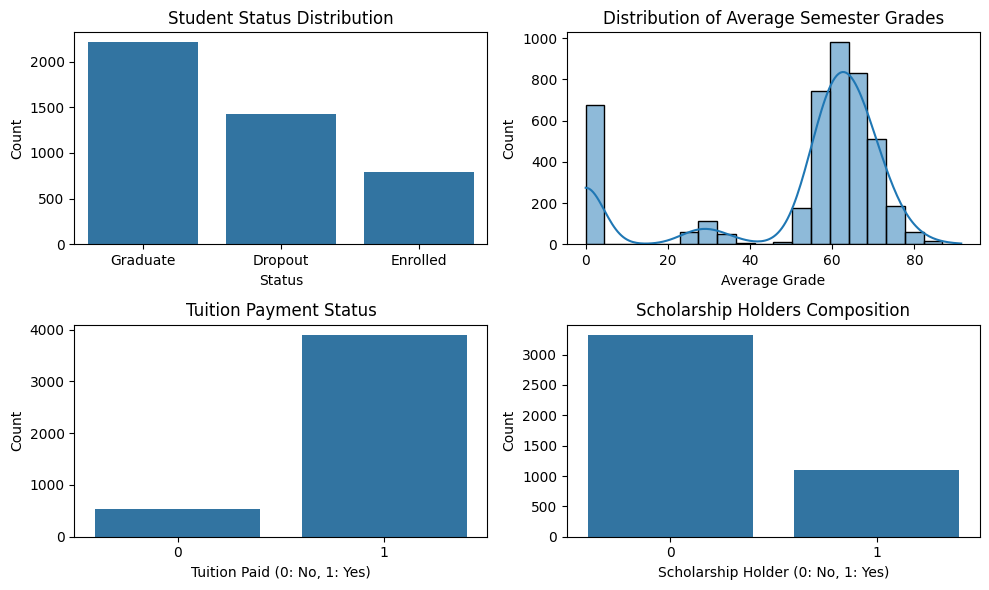

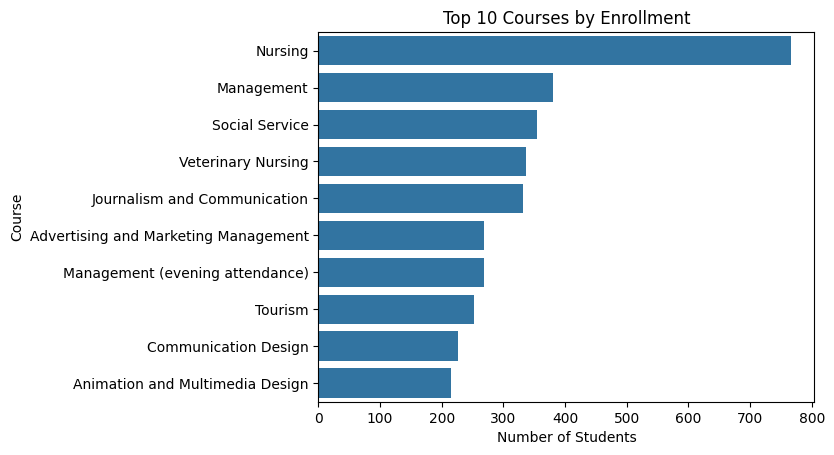

In [116]:
plt.figure(figsize=(10, 6))

# 1. Student Status Distribution
plt.subplot(2, 2, 1)
sns.countplot(data=dfa, x="status", order=dfa["status"].value_counts().index)
plt.title("Student Status Distribution")
plt.xlabel("Status")
plt.ylabel("Count")

# 2. Average Grade Distribution
dfa["avg_grade"] = (dfa["s1_grade"] + dfa["s2_grade"]) / 2
plt.subplot(2, 2, 2)
sns.histplot(dfa["avg_grade"], bins=20, kde=True)
plt.title("Distribution of Average Semester Grades")
plt.xlabel("Average Grade")
plt.ylabel("Count")

# 3. Tuition Payment Status
plt.subplot(2, 2, 3)
sns.countplot(data=dfa, x="is_tuition_paid", order=[0, 1])
plt.title("Tuition Payment Status")
plt.xlabel("Tuition Paid (0: No, 1: Yes)")
plt.ylabel("Count")

# 4. Scholarship Holders Composition
plt.subplot(2, 2, 4)
sns.countplot(data=dfa, x="is_scholarship_holder", order=[0, 1])
plt.title("Scholarship Holders Composition")
plt.xlabel("Scholarship Holder (0: No, 1: Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5. Top 10 study subjects
print('\n')
top_courses = dfa["course"].value_counts().nlargest(10)
sns.barplot(x=top_courses.values, y=top_courses.index)
plt.title("Top 10 Courses by Enrollment")
plt.xlabel("Number of Students")
plt.ylabel("Course")
plt.show()

***Conclusion***

- The majority of students have graduated at the time the data was collected.
- A significant portion of the collected students were also dropped out, while a smaller number are still enrolled at the time.

- Most students have average middle grade performance in around 65-70 international grade range.
- There are students with very low grades, even as low as 0. We might want to analyze this further and confirm whether these students are dropouts.

- Most students seem to have their tuition payment in place.
- Majority of the students are non-scholarship holders
- The study subject taken by most of the students in the dataset is nursing, followed by management and social services

#### Semester grade influence on dropout status

Do dropout students tend to have lower semester grades?

In [117]:
def perform_anova(df, num, cat, printInt=False):
  h0 = f"{num} and {cat} are not correlated"
  h1 = f"{num} and {cat} are correlated"

  groups = [df[num][df[cat] == val].dropna() for val in df[cat].unique()]
  F_stat, p_value = stats.f_oneway(*groups)

  if printInt:
    if p_value < 0.05:
      print(f"{h1}.\nF-stat: {F_stat:,.2f}\nP-value: {p_value:.3f}\n")
    else:
      print(f"{h0}.\nF-stat: {F_stat:,.2f}\nP-value: {p_value:.3f}\n")
  else:
    return F_stat, p_value

# correlation analysis between semester grade and student status with ANOVA (num x cat)
perform_anova(dfa, 'avg_grade', 'status', True)

avg_grade and status are correlated.
F-stat: 1,025.88
P-value: 0.000



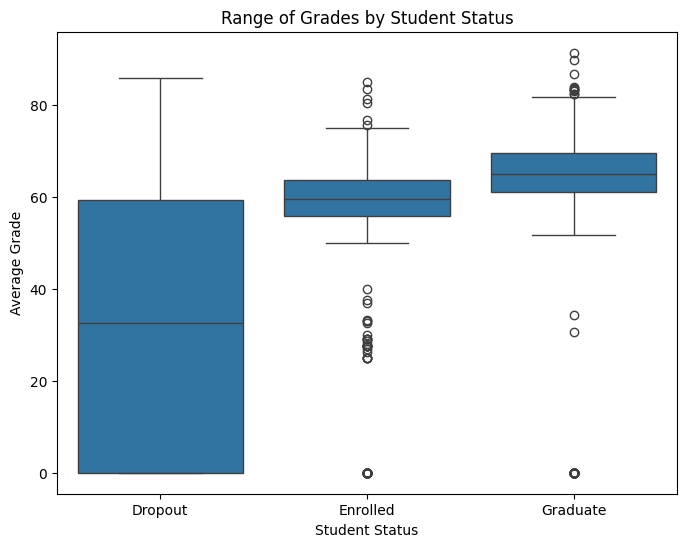

In [118]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dfa, x="status", y="avg_grade", order=["Dropout", "Enrolled", "Graduate"])
plt.title("Range of Grades by Student Status")
plt.xlabel("Student Status")
plt.ylabel("Average Grade")
plt.show()

***Insights***

- It is quite clear that the *average semester grade of dropout student is significantly lower* than those who graduated or is currently enrolled
- The grade range of those who dropped out are much larger than the ones who graduated or are still enrolled. This indicates that although there are correlation between average grade and academic status, but *average grades are not the sole driver behind students' drop-out status.*
- The very large f-stat shows that average semester grades differ greatly between students who drop out, remain enrolled, and graduate.
- The low p-value indicates that average grades are indeed strongly associated with student status.

***Detected Anomaly***

As can be seen from the chart, there are occurences where the student is already graduated, but they have 0 average grade. This is a very strange situation, as in the real world, one has to have a certain passing grade in order to graduate. There might be occurences where a few students might have low average score but managed to graduate due to exceptional extracurricular achievements, repeating terms, or taking additional courseworks. However, those grades would not be as extreme as 0 or close to 0 grades. This strongly indicates data entry error.

This is important to note for the purpose of building our model later, that these records might be better ***treated as data integrity anomaly*** (due to potential data entry error), since in real world, it's almost impossible for student to graduate with 0 grade.

In [119]:
# remove those who graduated with 0 average score
dfa = dfa[~((dfa['avg_grade'] == 0) & (dfa['status'] == 'Graduate'))]
dfa.shape

(4349, 38)


***CONCLUSION***

Yes, dropout students tend to have lower average semester grades compared to students with other statuses, however, average semester grade might not be the only strong driver behind student drop-out cases, as indicated by a large avg grade range amongst drop-out students.

#### Admission grade influence on student status

How does admission grade affect the likelihood of a student dropping out?

admission_grade and status are correlated.
F-stat: 27.89
P-value: 0.000



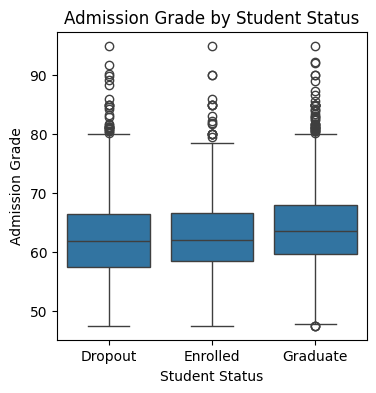

In [120]:
# correlation analysis between admission grade and student status with ANOVA (num x cat)
perform_anova(dfa, 'admission_grade', 'status', True)

plt.figure(figsize=(4, 4))
sns.boxplot(data=dfa, x="status", y="admission_grade", order=["Dropout", "Enrolled", "Graduate"])
plt.title("Admission Grade by Student Status")
plt.xlabel("Student Status")
plt.ylabel("Admission Grade")
plt.show()

***Insights***

The statistical correlation test suggests an strong correlation between admission grade and student academic status.

The very small p-value (close to zero) means that the difference in admission grades between the different status groups is highly significant, and that admission grade plays a significant role in determining students' academic status. The F-statistic of 35.65 also suggests that there is a strong difference in the means of admission grades across the three groups (Dropout, Enrolled, Graduate).

This analysis aligns with the visualized boxplot above, that higher admission grades correlate with better academic outcomes.

***CONCLUSION***

In summary, admission grades are a strong predictor of student status (whether they drop out, remain enrolled, or graduate). With those having higher admission grade, have potentially lower dropout risk.

#### Correlation: admission grade vs semester grade

Is there a correlation between admission grade and average semester grade?

Spearman corr: 0.2367, P-Value: 0.0000


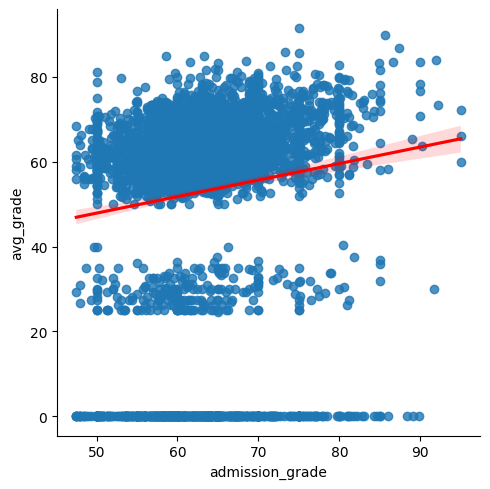

In [121]:
# Spearman correlation between admission grade and average semester grade
sns.lmplot(data=dfa,x='admission_grade', y='avg_grade', line_kws={'color':'red'})
spearman_corr, p_value_spearman = stats.spearmanr(dfa['admission_grade'], dfa['avg_grade'])
print(f'Spearman corr: {spearman_corr:,.4f}, P-Value: {p_value_spearman:,.4f}')

The Spearman correlation of 0.237 and p-value of close to 0 indicates a statistically significant weak positive correlation. This means that as admission grades increase, the average semester grades tend to increase as well, but the relationship is not very strong,

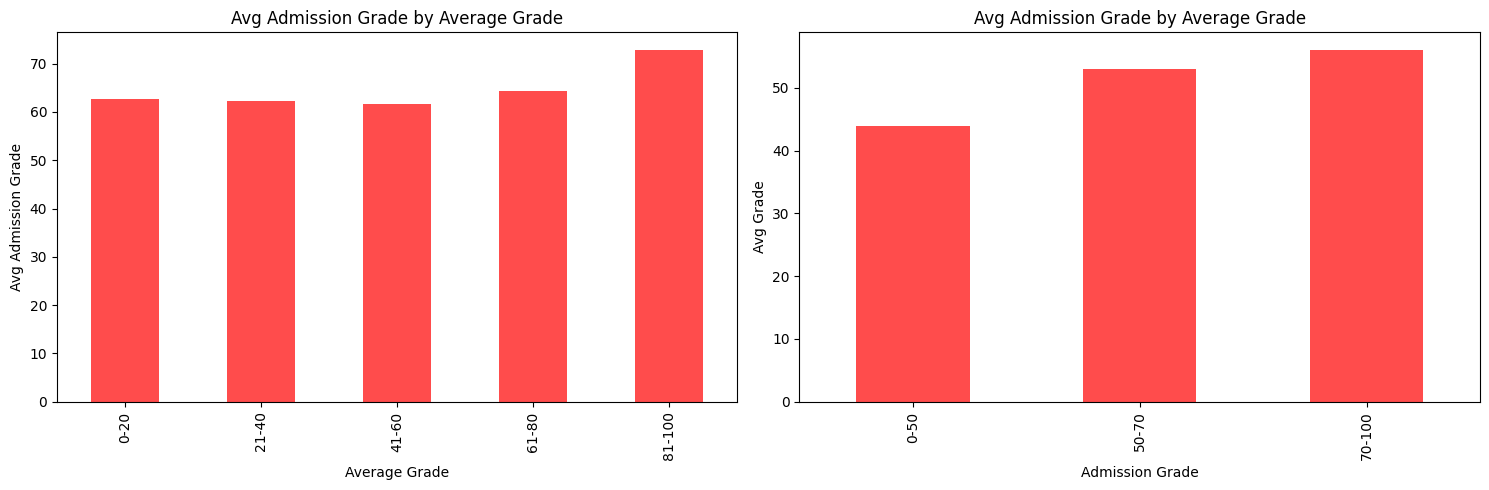

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
dfa["avg_grade_bin"] = pd.cut(dfa["avg_grade"], bins=bins, labels=labels, include_lowest=True)
avg_grade_grouped = dfa.groupby("avg_grade_bin", observed=False)["admission_grade"].mean()
avg_grade_grouped.plot(kind="bar", ax=ax[0], color="red", alpha=0.7)
ax[0].set_title("Avg Admission Grade by Average Grade")
ax[0].set_ylabel("Avg Admission Grade")
ax[0].set_xlabel("Average Grade")

bins = [0, 50, 70, 100]
labels = ['0-50', '50-70', '70-100']
dfa["avg_admission_grade_bin"] = pd.cut(dfa["admission_grade"], bins=bins, labels=labels, include_lowest=True)
admission_grade_grouped = dfa.groupby("avg_admission_grade_bin", observed=False)["avg_grade"].mean()
admission_grade_grouped.plot(kind="bar", ax=ax[1], color="red", alpha=0.7)
ax[1].set_title("Avg Admission Grade by Average Grade")
ax[1].set_ylabel("Avg Grade")
ax[1].set_xlabel("Admission Grade")

plt.tight_layout()
plt.show()


The bar charts indicates some relationship between admission grade and average semester grade when binned into groups

***CONCLUSION***

Yes, there is a statistically significant correlation between admission grade and average semester grade, however the correlation is not very strong, hence other factors likely play a larger role.

#### Courses and average student performance

Do different courses have different average grade and student status?

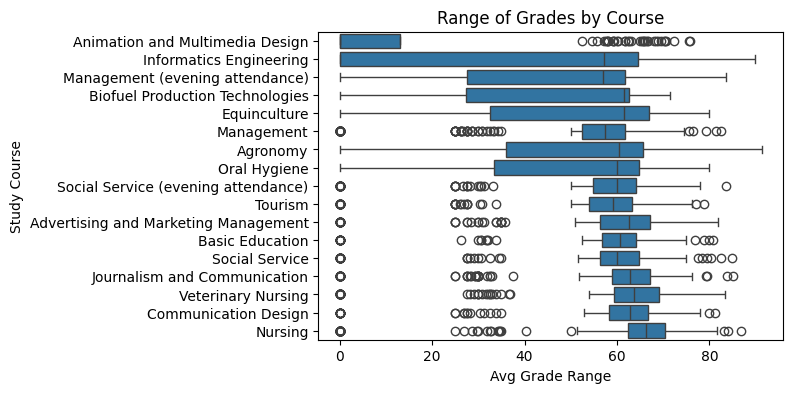

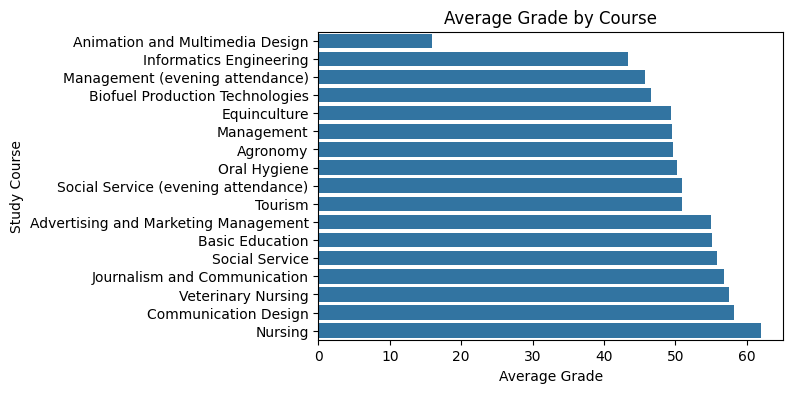

In [123]:
dfa_avg_grade_sorted = dfa.groupby("course").agg(
    avg_grade=("avg_grade", "mean")
).reset_index().sort_values(by="avg_grade", ascending=True)

plt.figure(figsize=(6, 4))
sns.boxplot(data=dfa, x="avg_grade", y="course", order=dfa_avg_grade_sorted['course'].unique())
plt.title("Range of Grades by Course")
plt.ylabel("Study Course")
plt.xlabel("Avg Grade Range")
plt.show()

print("\n")
plt.figure(figsize=(6, 4))
sns.barplot(data=dfa_avg_grade_sorted, x="avg_grade", y='course')
plt.title("Average Grade by Course")
plt.ylabel("Study Course")
plt.xlabel("Average Grade")
plt.show()

- Animation and Multimedia Design and Informatics Engineering stand out with the
the lowest average grades, which could point to either challenges in these fields or lower overall student achievement.
- These subjects also have very wide ranges in grades, indicating significant variability in student performance within these courses or varying difficulty levels.

- Nursing and Communication Design are on the higher end of the average grade spectrum. They also have more concentrated grade ranges and consistent performance, with minimal variation in grade distribution, which could suggest more uniformity in student performance.

- A general trend shows that more technical or specialized courses, like Informatics Engineering and Biofuel Production Technologies, tend to have lower average grades, possibly due to difficulty of the subject itself, or the high variability of student admissions criteria.

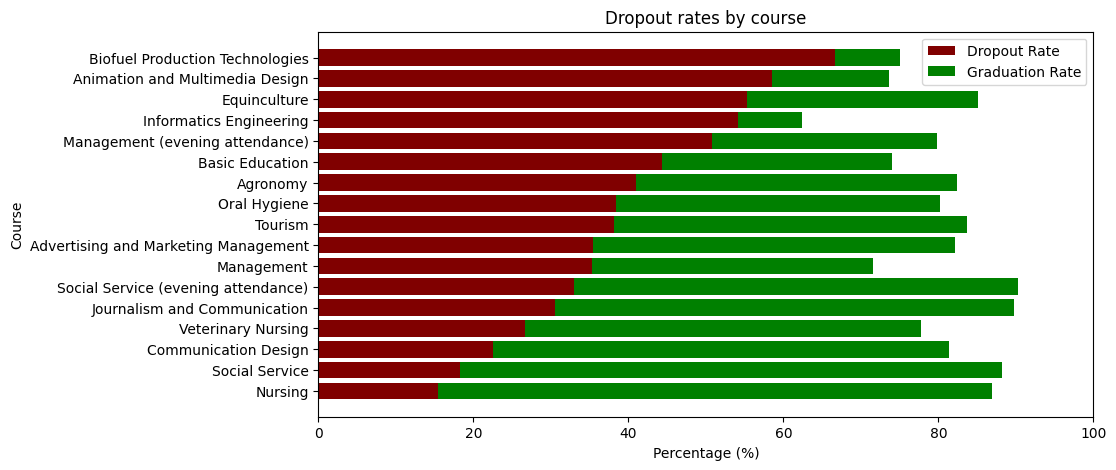

In [124]:
dfa_course_agg = dfa.groupby("course").agg(
    dropout_rate=("status", lambda x: (x == "Dropout").mean() * 100),
    graduation_rate=("status", lambda x: (x == "Graduate").mean() * 100),
).reset_index().sort_values(by="dropout_rate", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.barh(dfa_course_agg["course"], dfa_course_agg["dropout_rate"], label="Dropout Rate", color='maroon')
bars2 = ax.barh(dfa_course_agg["course"], dfa_course_agg["graduation_rate"], left=dfa_course_agg["dropout_rate"], label="Graduation Rate", color="green")

ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Course")
ax.set_title("Dropout rates by course")
ax.legend()
ax.set_xlim(0, 100)
ax.invert_yaxis()
plt.show()

Biofuel Production Technologies and Animation and Multimedia Design have the highest dropout rates, suggesting that students may struggle with these courses or that the fields themselves have higher barriers to completion.

On the other hand, Social Service (evening attendance) and Nursing have very high graduation rates, reflecting strong retention and success in these courses.

***CONCLUSION***

Yes, in average, different courses have quite sizeable differences in average grade and/or dropout rates.

A trend shown in the charts patterns shows us that:

- Courses with technical or specialized content tend to have wider grade ranges, lower average overall grades, and higher dropout rates, which could indicate that students face more challenges in these areas (due to the high difficulty of the subject), or that admissions to these courses acommodates for high student variability.

- Courses like Nursing and Social Service have better retention and relatively stable performance, possibly due to more relaxed curriculum, more supportive structures, more standardized admissions criteria, or better alignment with student expectations.

#### Macroeconomic affect on student dropout rates

Do economic data (unemployment rate, inflation, GDP) impact student dropout rates?

In [125]:
# Spearman correlation between admission grade and average semester grade
perform_anova(dfa, 'gdp', 'status', True)
perform_anova(dfa, 'unemployment_rate', 'status', True)
perform_anova(dfa, 'inflation_rate', 'status', True)

gdp and status are correlated.
F-stat: 5.01
P-value: 0.007

unemployment_rate and status are correlated.
F-stat: 5.95
P-value: 0.003

inflation_rate and status are not correlated.
F-stat: 1.62
P-value: 0.198



Based on the correlation analysis, GDP and unemployment_rate are statistically significant to student status. We can deep dive into those two variables

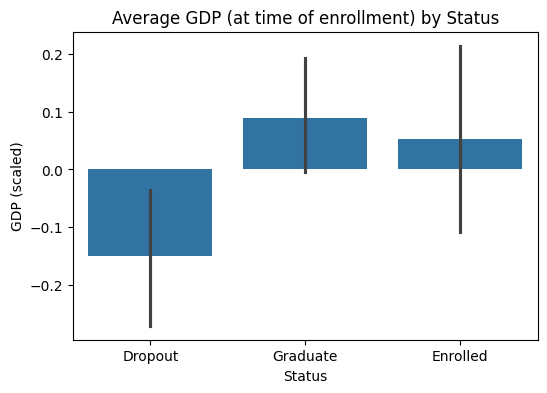

In [126]:
plt.figure(figsize=(6, 4))
sns.barplot(data=dfa, x="status", y='gdp')
plt.title("Average GDP (at time of enrollment) by Status")
plt.ylabel("GDP (scaled)")
plt.xlabel("Status")
plt.show()

Dropout students are majority enrolled when GDP is on the lower-end, ranging below zero (after scaled)

Whereas students who graduated or are currently enrolled have average positive scaled GDP (at time of enrollment). This signifies that gdp may play a role in sutdents' dropout risk

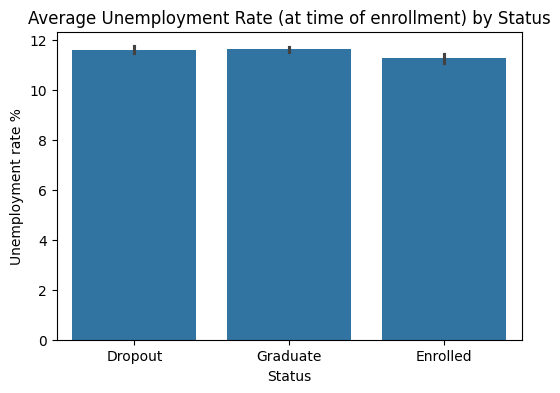

In [127]:
plt.figure(figsize=(6, 4))
sns.barplot(data=dfa, x="status", y='unemployment_rate')
plt.title("Average Unemployment Rate (at time of enrollment) by Status")
plt.ylabel("Unemployment rate %")
plt.xlabel("Status")
plt.show()

The chart does not show a very significant difference in average unemployment rate between dropout and graduate students. Although the anova correlation resulted in a significant correlation, the correlation might be weak.

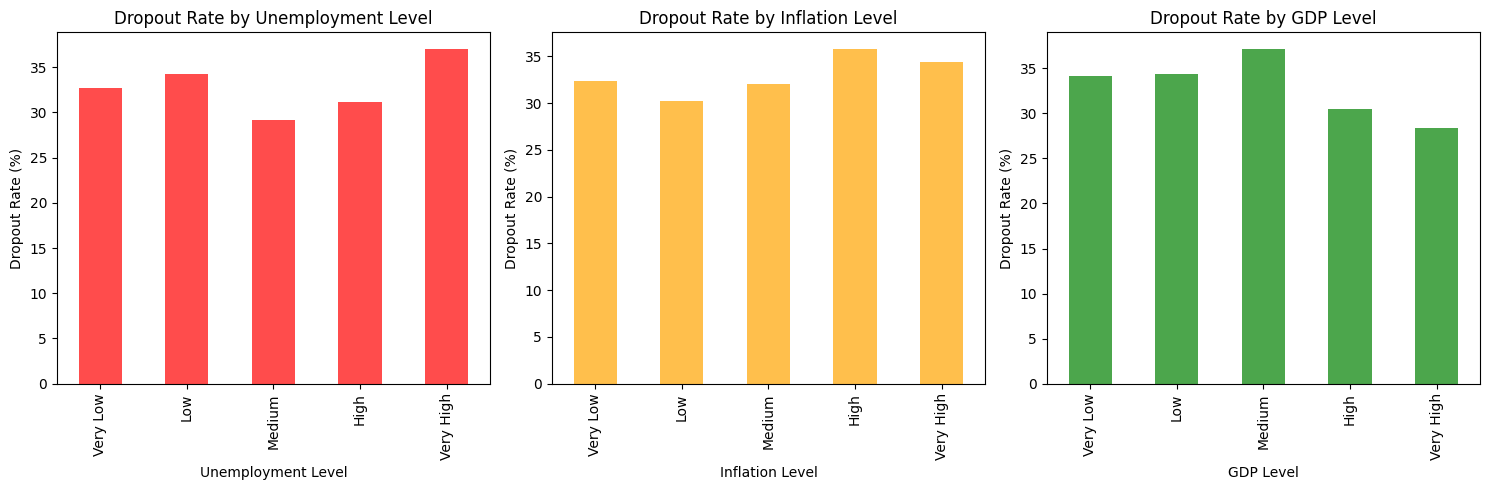

In [128]:
# Binning dropout rates based on economic conditions
dfa["unemployment_bin"] = pd.cut(dfa["unemployment_rate"], bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
dfa["inflation_bin"] = pd.cut(dfa["inflation_rate"], bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
dfa["gdp_bin"] = pd.cut(dfa["gdp"], bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

# Aggregating dropout rates per bin
dropout_by_unemployment = dfa.groupby("unemployment_bin", observed=False)["status"].apply(lambda x: (x == "Dropout").mean() * 100)
dropout_by_inflation = dfa.groupby("inflation_bin", observed=False)["status"].apply(lambda x: (x == "Dropout").mean() * 100)
dropout_by_gdp = dfa.groupby("gdp_bin", observed=False)["status"].apply(lambda x: (x == "Dropout").mean() * 100)

# Plot stacked bar chart
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Unemployment
dropout_by_unemployment.plot(kind="bar", ax=ax[0], color="red", alpha=0.7)
ax[0].set_title("Dropout Rate by Unemployment Level")
ax[0].set_ylabel("Dropout Rate (%)")
ax[0].set_xlabel("Unemployment Level")

# Inflation
dropout_by_inflation.plot(kind="bar", ax=ax[1], color="orange", alpha=0.7)
ax[1].set_title("Dropout Rate by Inflation Level")
ax[1].set_ylabel("Dropout Rate (%)")
ax[1].set_xlabel("Inflation Level")

# GDP
dropout_by_gdp.plot(kind="bar", ax=ax[2], color="green", alpha=0.7)
ax[2].set_title("Dropout Rate by GDP Level")
ax[2].set_ylabel("Dropout Rate (%)")
ax[2].set_xlabel("GDP Level")

plt.tight_layout()
plt.show()


- Dropout rates remain high across all unemployment levels, with no strong downward trend. This suggests that unemployment fluctuations may not be the main driver of student dropout rates.
- Dropout rates are also relatively stable across inflation levels. This suggests that inflation might have a small impact, potentially increasing dropout rates when it is high.
- Higher GDP looks to be correlates with lower dropout rates. There seems to be a negative trend on GDP compared to dropout rates, with some anomaly on the medium GDP bucket. However, this aligns with our previous findings that students who enrolled to the program during the time when the country is at lower GDP level, are at a higher risk of dropping out.

***CONCLUSION***

Some macroeconomic indicator might have effect on student dropout risk or rates:
- GDP has the strongest impact on dropout rates, with higher GDP associated with lower dropouts.
- Inflation and unemployment fluctuations do not show a clear-cut pattern, but high inflation might slightly increase dropouts.

This indicates that cconomic stability and financial resources likely play a significant role in student dropout risk, where those who enrolled in study program during the times when the country have stable or high GDP, tend to perform well, whereas those who enrolled during recession might have increased risk of dropout.

In [ ]:
dfa.to_csv('./data/student_data_analysis.csv', index=False)

# Feature Engineering

In this section, we will be preparing out dataset for model training.

- Missing value handling
- Anomaly data handling
- Cardinality checking
- Feature Creation
- Data Splitting
- Outlier Handling
- Feature Selection
- Feature Encoding
- Scaling

### Missing Value Handling

In [130]:
#check missing values
print(f'total missing values: {df.isna().sum().sum()}')

total missing values: 0


Similar to our previous result during overview, there is no missing value found in the dataset

### Remove Data Integrity Anomaly

As mentioned in our previous EDA result, there are possible data entry anomalies in our data that shows `graduated students` with 0 average semester grades, which is almost impossible in real world. This strongly suggest data error, and should be removed from dataset.

In [131]:
# remove those who graduated with 0 average score
df['avg_grade'] = (df["s1_grade"] + df["s2_grade"]) / 2
df = df[~((df['avg_grade'] == 0) & (df['status'] == 'Graduate'))]
df = df.drop(columns='avg_grade')
df.shape

(4349, 37)

### Cardinality Checking

In [132]:
for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values") if unique_count > 10 else print(f"{col}: {unique_count} unique values ==> {list(df[col].unique())}")

marital_status: 6 unique values ==> ['single', 'married', 'divorced', 'widower', 'facto union', 'legally separated']
application_mode: 18 unique values
course: 17 unique values
course_time: 2 unique values ==> ['daytime', 'evening']
education_level: 14 unique values
nationality: 21 unique values
mother_education: 23 unique values
father_education: 28 unique values
mother_occupation: 31 unique values
father_occupation: 43 unique values
gender: 2 unique values ==> ['male', 'female']
status: 3 unique values ==> ['Dropout', 'Graduate', 'Enrolled']


There are quite many high cardinality features, including `mother_education`, `father_education`, `mother_occupation`, `father_occupation`, `nationality`, `education_level`, `course`, and `application mode`. Our strategy to handle these are:

1. Check feature importance --> if any of these features are not important, we can drop it. We can do this before and after outlier handling
2. We can select models that works best with high-cardinality data, such as `CatBoost`, `Random Forest`, `Decision Tree`. This will also ensure that we retain most of the important data that might play important factor in training the model.
3. For `KNN` and `SVM`, since they don't work well with high-cardinality data, we can group high-cardinality features based on the highest count occurence.

We will adress these during feature selection and feature encoding

In [133]:
high_cardinality_features = ['mother_education', 'father_education', 'mother_occupation', 'father_occupation', 'nationality', 'education_level', 'course', 'application_mode']

### Data Splitting

We have 3 classes in our target column `status`: dropout, enrolled, and graduated. We can either make this into a 3-classes classification prediction, or 2-class classification and separating the other class as inference data.

As mentioned earlier in our objective, the focus of this model would be to predict whether a student would be more likely to drop-out or graduate. Hence, we only need it to be a two-class classification approach.

For this reason, we will be ***excluding*** those whose status is currently `enrolled`, as it does not provide much of meaningful insight to our model. Instead, we will use these data of students who are still in `enrolled` status as our inference data, which we will then try to predict whether they have higher tendency to dropout or graduate in their future course terms.

In [134]:
df['status'].value_counts()

status
Graduate    2134
Dropout     1421
Enrolled     794
Name: count, dtype: int64

In [135]:
# remove students currently enrolled
enrolled_students_df = df[df['status'] == 'Enrolled']
df = df[df['status'] != 'Enrolled']
print(df['status'].unique())
print(df.shape)

['Dropout' 'Graduate']
(3555, 37)


In [ ]:
enrolled_students = enrolled_students_df.drop(columns=['status'])
enrolled_students.to_csv('./data/enrolled_students_for_inf.csv', index=False)

In [137]:
test_size = 0.25
random_state = 42

# split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['status']), df['status'], test_size=test_size, random_state=random_state, stratify=df['status']) # ensure train and test have similar class balance
print(f'Train size : {X_train.shape}')
print(f'Test size : {X_test.shape}')

Train size : (2666, 36)
Test size : (889, 36)


***Check Class Balance***

In [138]:
def check_class_balance(y_train, y_test):
  '''
  function to check class balance of train and test set
  '''
  class_distribution_train = []
  for category, val in y_train.value_counts(normalize=True).items():
      class_distribution_train.append(f"{category}: {val * 100:.2f}%")

  class_distribution_test = []
  for category, val in y_test.value_counts(normalize=True).items():
      class_distribution_test.append(f"{category}: {val * 100:.2f}%")

  return {'train': class_distribution_train, 'test': class_distribution_test}

check_class_balance(y_train, y_test)

{'train': ['Graduate: 60.02%', 'Dropout: 39.98%'],
 'test': ['Graduate: 60.07%', 'Dropout: 39.93%']}

The classes of the target variable shows fairly balanced dataset with very mild imbalance (60-40), which should not be a major problem for our model. During training, we can apply class balancing hyperparameter when needed.

### Split cat vs num cols (post split)

In [139]:
status_index = categorical_columns.get_loc('status')
categorical_columns = categorical_columns.delete(status_index)
target_column = ['status']

### Outlier Handling

First, we need to check the distribution and skewness of each numerical features in order to detect outliers. We will only handle outliers for continuous numerical features and not binary or encoded ones.

In [140]:
continuous_numerical_columns = ['age_at_enrollment', 'previous_grade', 'admission_grade', 'unemployment_rate', 'inflation_rate', 'gdp']

skewness = {}
for col in continuous_numerical_columns:
  var = X_train[col]
  var_skew = var.skew()
  var_mean = var.mean()
  var_max = var.max()
  var_min = var.min()
  var_std = var.std()
  var_median = var.median()
  var_mode = var.mode()[0]
  var_range = var_max - var_min
  var_q1  = var.quantile(0.25)
  var_q3  = var.quantile(0.75)
  var_iqr = var_q3 - var_q1

  skewness[col] = [round(var_skew, 2), var_min, var_max, round(var_mean,2), var_median, var_q1, var_q3, var_iqr]

skew_table = pd.DataFrame(skewness).T
skew_table.columns = ['Skewness', 'Min', 'Max', 'Mean', 'Median', 'Q1', 'Q3', 'IQR']
skew_table

,Skewness,Min,Max,Mean,Median,Q1,Q3,IQR
age_at_enrollment,1.95,17.00,70.00,23.54,20.000,19.00,26.00,7.00
previous_grade,0.29,47.50,95.00,66.37,66.550,62.00,70.00,8.00
admission_grade,0.53,47.50,95.00,63.48,63.125,58.85,67.50,8.65
unemployment_rate,0.20,7.60,16.20,11.63,11.100,9.40,13.90,4.50
inflation_rate,0.26,-0.80,3.70,1.24,1.400,0.30,2.60,2.30
gdp,-0.38,-4.06,3.51,-0.00,0.320,-1.70,1.79,3.49


Based on above skewness analysis, most numerical variables are normally distributed, except age. Consistent with our earlier analysis during EDA, we know that there are some very old people (up to 70 years old) who are in the dataset. Since in the real world, people of those age are also unlikely to be allowed to pursue a degree-program, we will need to handle this.

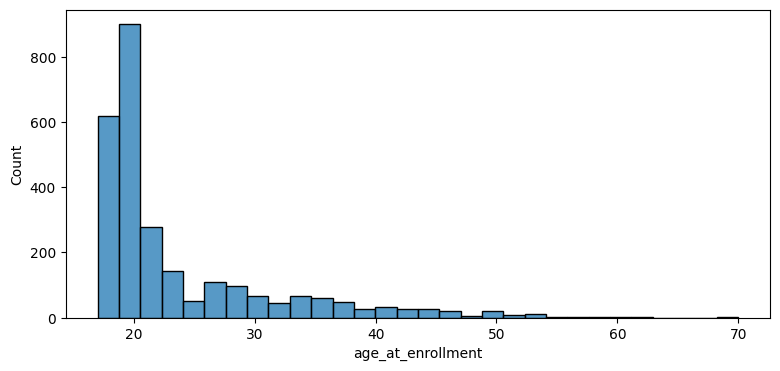

In [141]:
distribution_histplot(1, X_train, X_train, 'age_at_enrollment', '', 20, 4, 30, '', '')

In [142]:
# count age ouliers
age_dist = skewness['age_at_enrollment']
age = X_train['age_at_enrollment']
multiplier = 3
lower_boundary = max(0, age_dist[5] - (age_dist[7] * multiplier))
upper_boundary = age_dist[6] + (age_dist[7] * multiplier)

print("Lower Boundary of age:", "{:,.2f}".format(lower_boundary), f'years old')
print("Upper Boundary of age:", "{:,.2f}".format(upper_boundary), f'years old')

# % of outliers
outliers = age[(age>upper_boundary)]
number_of_outliers = outliers.count()
percentage_outlier = number_of_outliers/(len(age))*100
print(f'Number of outliers = {number_of_outliers}')
print(f'Percentage of outliers = {percentage_outlier:,.2f}%')

Lower Boundary of age: 0.00 years old
Upper Boundary of age: 47.00 years old
Number of outliers = 55
Percentage of outliers = 2.06%


From our outlier analysis, there are 116 students who are defined as outliers (older than 43 years old).

However, in real world, there are still possibility for people even as old as 45 to enroll as student. If we handle outlier with threshold of 43 years old, we might remove some actual meaningful data that are actual/natural outliers.

Hence we will use ***quantile-based*** winsorization method at the 99th quantile to lower the capping criteria.

In [143]:
upper_boundary = np.percentile(age, 99)
print("Upper Boundary of age:", "{:,.2f}".format(upper_boundary), f'years old')
outliers = age[(age>upper_boundary)]
number_of_outliers = outliers.count()
percentage_outlier = number_of_outliers/(len(age))*100
print(f'Number of outliers = {number_of_outliers}')
print(f'Percentage of outliers = {percentage_outlier:,.2f}%')

Upper Boundary of age: 51.00 years old
Number of outliers = 24
Percentage of outliers = 0.90%


In [144]:
capped_cols = 'age_at_enrollment'
winsorizer = Winsorizer(capping_method="quantiles", tail="right", fold=0.01, variables='age_at_enrollment')  # Capping at 99th percentile

### Feature Selection

#### Using Feature Importance

In [145]:
def get_feature_importance(X_train, y_train, categorical_columns):
  X_train_FI = pd.get_dummies(X_train,
                              prefix={col: col for col in categorical_columns},
                              prefix_sep='===',
                              columns=categorical_columns)

  # Encode target labels
  label_encoder = LabelEncoder()
  y_train_FI = label_encoder.fit_transform(y_train)

  model = RandomForestClassifier(n_estimators=100)
  model.fit(X_train_FI, y_train_FI)

  # Get feature importance
  importances = model.feature_importances_

  feat_importances = pd.Series(importances, index=X_train_FI.columns)

  # original features
  feat_importances.index = feat_importances.index.str.split('===').str[0]
  grouped_importance = feat_importances.groupby(feat_importances.index).mean()
  importance_df = grouped_importance.sort_values(ascending=False)

  return importance_df

importance_matrix = get_feature_importance(X_train, y_train, categorical_columns)
importance_df = pd.DataFrame({
    'Feature': importance_matrix.index,
    'avg_importance': importance_matrix.values,
    'is_high_cardinality': [col in high_cardinality_features for col in importance_matrix.index]
})

# Sort by THE LEAST importance
importance_df = importance_df.sort_values(by='avg_importance', ascending=True)
importance_df = importance_df.reset_index(drop=True)
display(importance_df)


,Feature,avg_importance,is_high_cardinality
0,nationality,0.000099,True
1,has_special_needs,0.000282,False
2,is_international,0.000518,False
3,education_level,0.000647,True
4,father_occupation,0.000698,True
5,marital_status,0.000779,False
6,father_education,0.000804,True
7,mother_education,0.000838,True
8,mother_occupation,0.000854,True
9,application_mode,0.001453,True


As we can see, all of the high cardinality features falls within the top 11 LEAST important features. So it might be safe to remove those features altogether, given the low importance.

However, to reduce the impact of removing potentially important information, we can cherry-pick some of these features based on domain knowledge and real-world reasoning. Features safe to be removed based on importance and logic:

- nationality
- father_occupation
- mother_occupation
- father_education
- mother_education
- application_mode

And these features will be kept due to potential impact towards student' success, based on real-world domain knowledge and rationale:

- education_level: in real-world, a higher education level background might contribute to someone's study performance. This is why many universities ask for a minimum educational level prior to admitting the students
- course: this feature is NOT in the top 10 in lowest importance, and logically, a course might have higher difficulty or passing grade, that impacts students' ease to graduate


In [146]:
columns_to_remove = [
    'nationality',
    'father_occupation',
    'mother_occupation',
    'father_education',
    'mother_education',
    'application_mode'
    ]

#### Multicollinearity - Categorical Variables

In [147]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical correlation"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

In [148]:
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))),
                                index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

cramers_v_matrix

,marital_status,application_mode,course,course_time,education_level,nationality,mother_education,father_education,mother_occupation,father_occupation,gender
marital_status,0.000000,0.230126,0.187874,0.372803,0.162678,0.045636,0.158337,0.141480,0.093069,0.104597,0.088699
application_mode,0.230126,0.000000,0.181258,0.410571,0.462930,0.244465,0.124860,0.134948,0.143105,0.135508,0.221648
course,0.187874,0.181258,0.000000,1.000000,0.138826,0.086373,0.138304,0.131198,0.134007,0.146013,0.412975
course_time,0.372803,0.410571,1.000000,0.000000,0.189632,0.033858,0.286855,0.254055,0.185510,0.163676,0.037000
education_level,0.162678,0.462930,0.138826,0.189632,0.000000,0.034699,0.112660,0.126524,0.125398,0.122857,0.148710
nationality,0.045636,0.244465,0.086373,0.033858,0.034699,0.000000,0.103191,0.148251,0.092362,0.076448,0.085111
mother_education,0.158337,0.124860,0.138304,0.286855,0.112660,0.103191,0.000000,0.448890,0.285637,0.236821,0.128921
father_education,0.141480,0.134948,0.131198,0.254055,0.126524,0.148251,0.448890,0.000000,0.194320,0.232611,0.135172
mother_occupation,0.093069,0.143105,0.134007,0.185510,0.125398,0.092362,0.285637,0.194320,0.000000,0.614227,0.115856
father_occupation,0.104597,0.135508,0.146013,0.163676,0.122857,0.076448,0.236821,0.232611,0.614227,0.000000,0.139932


***Observations***

`course and course_time`:

This pair has a Cramér's V value of 1.0, indicating a perfect association. This suggests that knowing the course will perfectly predict the course time, meaning they are perfectly correlated in the dataset. We will remove one of these to reduce multicollinearity.

Other pairs: Most of the off-diagonal values seem to range between 0.1 to 0.4, indicating weak to moderate associations between different categorical variables.

Since `course_time` has lower importance score, and also covers less granular information, we will remove course time and retain course.

In [149]:
unique_courses_evening = X_train[X_train['course_time'] == 'evening']['course'].unique()
print(unique_courses_evening)

['Social Service (evening attendance)' 'Management (evening attendance)']


We can see why `course` and `course_time` has strong correlation, because there is a redundant value of evening attendance. For this, we can modify `course` and reduce its cardinality while lowering the multicollinearity between the two features. We will do this later in feature transformation

#### Multicollinearity - Numerical Variables

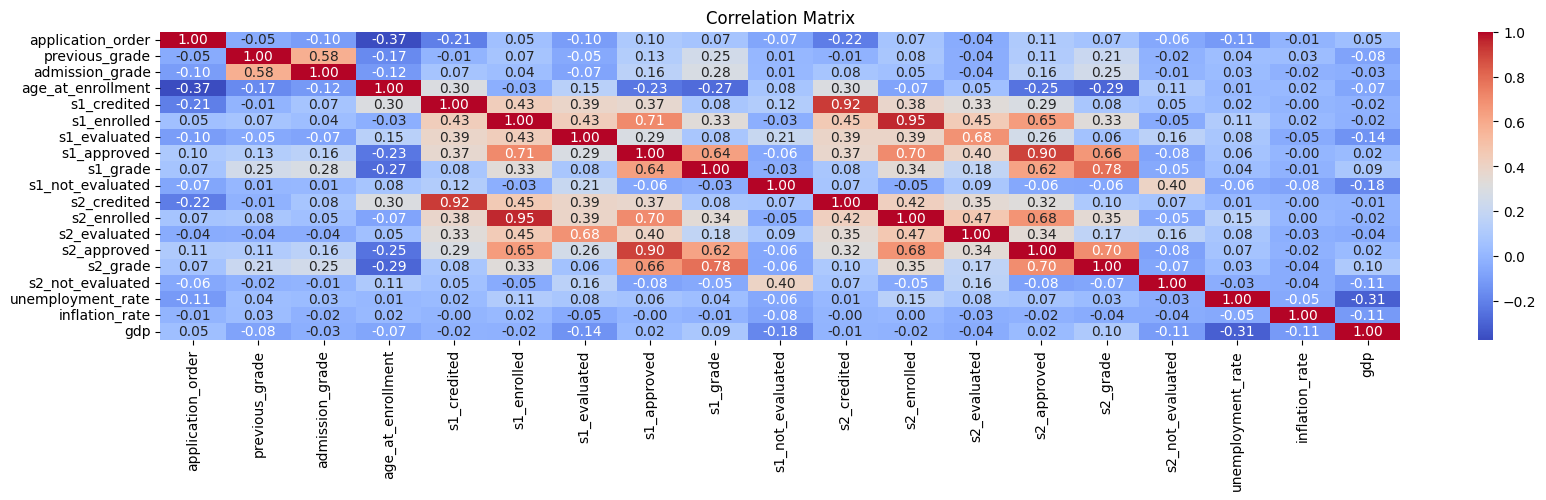

In [150]:
correlation_matrix = X_train[numerical_columns].corr('spearman')

plt.figure(figsize=(20, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=90)
plt.title("Correlation Matrix")
plt.show()

In [151]:
# check VIF
def checkVIF(data):
  X_vif = data.copy()
  vif_data = pd.DataFrame()
  vif_data["Feature"] = X_vif.columns
  vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
  vif_data = vif_data.sort_values(by="VIF", ascending=False)
  return vif_data

vif_data = checkVIF(X_train[numerical_columns])
print("\n", vif_data)


               Feature         VIF
5         s1_enrolled  159.197111
11        s2_enrolled  137.919645
1      previous_grade  119.367060
2     admission_grade  110.037586
7         s1_approved   50.286500
13        s2_approved   37.850986
8            s1_grade   29.969074
14           s2_grade   27.330523
16  unemployment_rate   21.498731
6        s1_evaluated   19.088535
4         s1_credited   17.182722
12       s2_evaluated   16.984836
10        s2_credited   13.652864
3   age_at_enrollment   11.196428
0   application_order    2.972811
17     inflation_rate    1.881765
9    s1_not_evaluated    1.692245
15   s2_not_evaluated    1.564637
18                gdp    1.194380


**Strong Positive Correlations:**

- `admissions_grade` and `previous_grade`

A score of 0.57 indicates a moderate-strong correlation between these two features. However, they have extremely high VIF which indicates strong multicollinearity. Hence, it might be better to drop one of it. Since `admissions_grade` have higher feature importance score and lower VIF, we will retain that feature and remove `previous_grade` instead.

- `s1_enrolled and s2_enrolled`:

The correlation value is 0.96, indicating a very strong positive relationship between the variables `s1_enrolled` and `s2_enrolled`. They also have extremely high VIF which indicates high multicollinearity.

- `s1_credited and s2_credited`:

The correlation value is 0.93, showing a strong positive relationship between the variables `s1_credited` and `s2_credited`.

- `s1_approved and s2_approved`:

The correlation value is 0.91, showing a strong positive relationship between the variables `s1_approved` and `s2_approved`.

The above figure indicates that most likely majority of students still have the same number of subjects enrolled, credited, and approved from semester 1 as of end of semester 2, hence the number does not change much.

Due to the high correlation between semester 1 and semester 2 values, we will drop all the semester-1 related subject numbers and keep only the semester-2 to reduce multicollinearity.

In [152]:
columns_to_remove.extend(['s1_enrolled', 's1_credited', 's1_approved', 's1_evaluated', 's1_not_evaluated', 'previous_grade'])

#### Correlation to Target Variable

Next, we check correlation between the features and target variable.

We will use phik to calculate correlation, since our features consist of numerical and categorical data

In [153]:
def compute_phik_correlation(dataframe, columns, target):
    '''
    function to calculate correlation of features and target
    '''
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix[target]

columns_to_keep = list(set(X_train.columns) - set(columns_to_remove))

concat_train = pd.concat([X_train[columns_to_keep], y_train], axis=1)
correlation = compute_phik_correlation(concat_train, concat_train.columns, [y_train.name])
zero_correlation = correlation[correlation == 0]
zero_correlation = zero_correlation.dropna(how='all', axis=0).dropna(how='all', axis=1)

zero_correlation

interval columns not set, guessing: ['inflation_rate', 'is_international', 's2_evaluated', 'has_special_needs', 'is_debtor', 'application_order', 'unemployment_rate', 's2_enrolled', 'admission_grade', 'gdp', 's2_approved', 's2_not_evaluated', 's1_grade', 's2_credited', 's2_grade', 'is_displaced', 'is_tuition_paid', 'is_scholarship_holder', 'age_at_enrollment']


,status
is_international,0.0
has_special_needs,0.0


Beyond the other columns that we've identified as not important or have high multicollinearity, there are still 2 columns with ZERO correlation to the target variable according to PHIK correlation: `has_special_needs` and `is_international`.

We know previously that both of these have low importance, but know we are confirming that these two have zero correlation to the target variable according to phik score calculation, hence we can drop them to keep our model simpler.


In [154]:
columns_to_remove.extend(['has_special_needs', 'is_international'])
columns_to_remove

['nationality',
 'father_occupation',
 'mother_occupation',
 'father_education',
 'mother_education',
 'application_mode',
 's1_enrolled',
 's1_credited',
 's1_approved',
 's1_evaluated',
 's1_not_evaluated',
 'previous_grade',
 'has_special_needs',
 'is_international']

#### Remove columns

In [155]:
# drop columns to be removed
X_train = X_train.drop(columns=columns_to_remove)
X_test = X_test.drop(columns=columns_to_remove)
X_train.shape

(2666, 22)

In [156]:
# re-declare cat_cols
categorical_columns = X_train.select_dtypes(include=['object']).columns
binary_columns = ['is_displaced', 'is_debtor', 'is_tuition_paid', 'is_scholarship_holder']
numerical_columns = [col for col in X_train.columns if col not in categorical_columns and col not in binary_columns]

column_type_summary = {
    "categorical": categorical_columns,
    "binary": binary_columns,
    "numerical": numerical_columns
}

column_summary_type = pd.DataFrame.from_dict(column_type_summary, orient='index').transpose()
column_summary_type.fillna("-", inplace=True)
column_summary_type

,categorical,binary,numerical
0,marital_status,is_displaced,application_order
1,course,is_debtor,admission_grade
2,course_time,is_tuition_paid,age_at_enrollment
3,education_level,is_scholarship_holder,s1_grade
4,gender,-,s2_credited
5,-,-,s2_enrolled
6,-,-,s2_evaluated
7,-,-,s2_approved
8,-,-,s2_grade
9,-,-,s2_not_evaluated


*Check VIF post removal*

In [157]:
# check VIF
def checkVIF(data):
  X_vif = data.copy()
  vif_data = pd.DataFrame()
  vif_data["Feature"] = X_vif.columns
  vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
  vif_data = vif_data.sort_values(by="VIF", ascending=False)
  return vif_data

vif_data = checkVIF(X_train[numerical_columns])
print("\n", vif_data)


               Feature        VIF
5         s2_enrolled  34.567291
1     admission_grade  34.524317
8            s2_grade  26.393592
3            s1_grade  21.041880
10  unemployment_rate  20.461224
7         s2_approved  20.383088
2   age_at_enrollment  10.801667
6        s2_evaluated  10.333934
0   application_order   2.942266
4         s2_credited   2.936318
11     inflation_rate   1.838404
12                gdp   1.152949
9    s2_not_evaluated   1.109976


From the new VIF, we can still see some high multicollinearity features. We can add `s2_enrolled` to be removed since it might already be represented by s2_approved. We might also be able to remove admission_grade, however, given that it has moderately high importance, we can keep the feature.

We will also be removing unemployment rate and inflation rate, since it has a moderate VIF and low importance

In [158]:
additional_columns_to_remove = ['s2_enrolled', 'unemployment_rate', 'inflation_rate']
columns_to_remove.extend(additional_columns_to_remove)

# drop columns to be removed
X_train = X_train.drop(columns=additional_columns_to_remove)
X_test = X_test.drop(columns=additional_columns_to_remove)
X_train.shape

(2666, 19)

In [159]:
# re-declare cat_cols
categorical_columns = X_train.select_dtypes(include=['object']).columns
binary_columns = ['is_displaced', 'is_debtor', 'is_tuition_paid', 'is_scholarship_holder']
numerical_columns = [col for col in X_train.columns if col not in categorical_columns and col not in binary_columns]

column_type_summary = {
    "categorical": categorical_columns,
    "binary": binary_columns,
    "numerical": numerical_columns
}

column_summary_type = pd.DataFrame.from_dict(column_type_summary, orient='index').transpose()
column_summary_type.fillna("-", inplace=True)
column_summary_type

,categorical,binary,numerical
0,marital_status,is_displaced,application_order
1,course,is_debtor,admission_grade
2,course_time,is_tuition_paid,age_at_enrollment
3,education_level,is_scholarship_holder,s1_grade
4,gender,-,s2_credited
5,-,-,s2_evaluated
6,-,-,s2_approved
7,-,-,s2_grade
8,-,-,s2_not_evaluated
9,-,-,gdp


***Conclusion: Feature Selection***

Columns removed:

| Feature Name        | Reason to Remove                                         |
|---------------------|----------------------------------------------------------|
| nationality         | high cardinality, low importance                         |
| father_occupation   | high cardinality, low importance                         |
| mother_occupation   | high cardinality, low importance                         |
| father_education    | high cardinality, low importance                         |
| mother_education    | high cardinality, low importance                         |
| application_mode    | high cardinality, low importance                         |
| s1_enrolled         | high VIF & high correlation with s2_enrolled             |
| s1_credited         | multicollinearity (high correlation with s2_credited)    |
| s1_approved         | multicollinearity (high correlation with s2_approved)    |
| s1_evaluated         | multicollinearity (high correlation with s2_evaluated)    |
| s1_not_evaluated         | multicollinearity (high correlation with s2_not_evaluated)    |
| previous_grade      | high VIF & high correlation with admissions_grade        |
| has_special_needs   | low importance, zero phik correlation score              |
| is_international    | low importance, zero phik correlation score              |
| s2_enrolled         | multicollinearity (high correlation with average_grade and s2_approved)    |
| unemployment_rate   | high VIF, low correlation to target variable    |
| inflation_rate   | low importance to target variable    |


### Feature Creation & Transformation

First, we remove all course_time indicator from course to reduce multicollinearity between course and course_time.

Then, we can see `course` and `education_level` still has high cardinality. We will handle this by re-categorizing them based on frequency occurence

In [160]:
# cardinality
for col in categorical_columns:
  print(f"{col}: {X_train[col].nunique()}")

marital_status: 6
course: 17
course_time: 2
education_level: 14
gender: 2


In [161]:
# check top 10 courses based on top occurence in X_train only
X_train['course'] = X_train['course'].str.replace(r' \(evening attendance\)', '', regex=True)
category_counts = X_train['course'].value_counts()
top_10_courses = category_counts.head(10).index
top_10_courses

Index(['Nursing', 'Social Service', 'Management',
       'Journalism and Communication', 'Veterinary Nursing',
       'Advertising and Marketing Management', 'Tourism',
       'Communication Design', 'Agronomy', 'Basic Education'],
      dtype='object', name='course')

In [162]:
def recategorize_course(data):
    '''
    function to recategorize course based on top 10 courses in X_train
    '''
    top_10_courses = ['Nursing', 'Social Service', 'Management',
       'Journalism and Communication', 'Veterinary Nursing',
       'Advertising and Marketing Management', 'Tourism',
       'Communication Design', 'Agronomy', 'Basic Education']
    data['course'] = data['course'].str.replace(r' \(evening attendance\)', '', regex=True)
    data['course'] = data['course'].apply(lambda x: x if x in top_10_courses else 'Others')
    return data

In [163]:
# recategorize education based on level groupings
def recategorize_education_level(data):
  for val in data.education_level.unique():
    education_grouping = {
      'Secondary': 'Secondary',
      'Bachelors degree': 'Bachelors degree',
      'Higher education (diploma)': 'Diploma',
      'Masters degree': 'Masters degree',
      'Doctorate degree': 'Doctorate degree',
      '12th grade - not completed': 'Secondary - not completed',
      '11th grade - not completed': 'Secondary - not completed',
      '7th grade': 'Secondary - not completed',
      '11th-grade': 'Secondary - not completed',
      '2nd-year complementary high school': 'Secondary - not completed',
      '10th grade': 'Secondary - not completed',
      '10th grade - not completed': 'Secondary - not completed',
      'General commerce course': 'Diploma',
      'Basic 3rd cycle (9th-11th)': 'Secondary - not completed',
      'Complementary high school': 'Secondary',
      'Technical/professional course': 'Diploma',
      'Incomplete high school': 'Secondary - not completed',
      'Basic 2nd cycle (6th-8th)': 'Secondary - not completed',
      '9th grade - not completed': 'Secondary - not completed',
      '8th grade': 'Secondary - not completed',
      'Administration & commerce course': 'Diploma',
      'Supplementary accounting & admin': 'Diploma',
      'Unknown': 'Others',
      'Illiterate': 'Illiterate',
      'Can read, no formal schooling': 'Informal Education',
      'Basic 1st cycle (4th-5th)': 'Primary',
      'Technological specialization': 'Diploma',
      'Specialized higher studies': 'Diploma',
      'Professional higher technical course': 'Diploma'
    }
    if val in education_grouping:
        data.loc[data.education_level == val, 'education_level'] = education_grouping[val]
  return data

### Feature Encoding

In feature encoding, we will do encoding to the categorical columns. All the categorical columns are nominal categories so we will do `one-hot-encoding`

In [164]:
# declare OHE encoder
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

### Target Encoding

Because LabelEncoder will encode the target values alphabetically, and we want our `Dropout` value to be class 1 (our key observed value), we will do manual mapping

In [165]:
target_mapping = {
    'Dropout': 1,
    'Graduate': 0
}

y_train = y_train.map(target_mapping)
y_test = y_test.map(target_mapping)

### Scaling

Since majority of the columns are normally distributed except `age`, and after outlier-handling, `age` might represent actual variance of students' ages, we will be applying `standard-scaler` for scaling.

In [166]:
scaler = StandardScaler()

### Column Transformer

We will now create column transformer for our data preprocessing which will include winsorizing, encoding, and scaling.

As mentioned above, the encoding will differ based on the model that we use

In [167]:
categorical_pipeline = Pipeline([
    ('transform_course', FunctionTransformer(recategorize_course, validate=False)),
    ('transform_education', FunctionTransformer(recategorize_education_level, validate=False)),
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Others')),  # Handle missing values
    ('encoder', ohe)  # Encode categorical
])

In [168]:
numerical_pipeline = Pipeline([
    ('winsorizer', winsorizer),
    ('imputer_num', SimpleImputer(strategy='median')), # Handle missing values,
    ('scaler', scaler)
])

In [169]:
transformer = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_columns),
    ('categorical_pipeline', categorical_pipeline, categorical_columns),
], remainder='passthrough', force_int_remainder_cols=False)

# Model Definition

In [170]:
model_names = ['KNN', 'SVM', 'DecisionTree', 'RandomForest', 'CatBoost']

For boosting algorithm, we will be using CatBoost because catboost is the best model for high-cardinality and high-dimensional data. Our data shows there are several features with high-cardinality categorical values, so this model serves it the best

In [171]:
def createModelPipeline(preprocessor, classifier):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

model_knn = createModelPipeline(transformer, KNeighborsClassifier())
model_svm = createModelPipeline(transformer, SVC(probability=True, random_state=random_state))
model_dtree = createModelPipeline(transformer, DecisionTreeClassifier(random_state=random_state))
model_rf = createModelPipeline(transformer, RandomForestClassifier(random_state=random_state))
model_cb = createModelPipeline(transformer, CatBoostClassifier(random_state=random_state, verbose=False))

models = [model_knn, model_svm, model_dtree, model_rf, model_cb]

# Model Training

In [172]:
for model in models:
  display(model.fit(X_train, y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.01,
                                                                              variables='age_at_enrollment')),
                                                                  ('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['application_order'...
                                                                   FunctionTransformer(func=<function recategorize_education_level at 0x000001C80E32DF30>)),
                                                                  ('imputer_cat',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['marital_status', 'course', 'course_time', 'education_level', 'gender'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.01,
                                                                              variables='age_at_enrollment')),
                                                                  ('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['application_order'...
                                                                   FunctionTransformer(func=<function recategorize_education_level at 0x000001C80E32DF30>)),
                                                                  ('imputer_cat',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['marital_status', 'course', 'course_time', 'education_level', 'gender'], dtype='object'))])),
                ('classifier', SVC(probability=True, random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.01,
                                                                              variables='age_at_enrollment')),
                                                                  ('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['application_order'...
                                                                   FunctionTransformer(func=<function recategorize_education_level at 0x000001C80E32DF30>)),
                                                                  ('imputer_cat',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['marital_status', 'course', 'course_time', 'education_level', 'gender'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.01,
                                                                              variables='age_at_enrollment')),
                                                                  ('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['application_order'...
                                                                   FunctionTransformer(func=<function recategorize_education_level at 0x000001C80E32DF30>)),
                                                                  ('imputer_cat',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['marital_status', 'course', 'course_time', 'education_level', 'gender'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.01,
                                                                              variables='age_at_enrollment')),
                                                                  ('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['application_order'...
                                                                   FunctionTransformer(func=<function recategorize_education_level at 0x000001C80E32DF30>)),
                                                                  ('imputer_cat',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['marital_status', 'course', 'course_time', 'education_level', 'gender'], dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001C8109920E0>)])

# Model Evaluation

In [173]:
class_names = ['Graduate', 'Dropout']

def generateComparisonReport(model, xtrain, ytrain, xtest, ytest, minimized):
    """
    Generate a comparison report of Train vs Test performance
    to evaluate model fit (overfitting vs underfitting).
    """

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_report = classification_report(ytrain, y_train_pred, output_dict=True, target_names = class_names)
    test_report = classification_report(ytest, y_test_pred, output_dict=True, target_names = class_names)

    df_train = pd.DataFrame(train_report).T.loc[class_names] if minimized else pd.DataFrame(train_report).T
    df_test = pd.DataFrame(test_report).T.loc[class_names] if minimized else pd.DataFrame(test_report).T

    df_train = df_train.apply(lambda col: col.map(lambda x: round(x * 100, 2) if col.name != "support" else x))
    df_test = df_test.apply(lambda col: col.map(lambda x: round(x * 100, 2) if col.name != "support" else x))

    # overfitting/underfitting analysis
    df_comparison = df_train[['recall']].subtract(df_test[['recall']])
    df_comparison.rename(columns=lambda x: x + " (Train-Test)", inplace=True)
    df_comparison = df_comparison.map(lambda x: round(x, 2))

    df_test['train-test (recall)'] = df_comparison['recall (Train-Test)']

    print("\nTEST CLASSIFICATION REPORT")
    display(df_test.apply(lambda col: col.map(lambda x: f"{x}%" if col.name != 'support' else x)))
    print('\n','-'*50,'\n')

    # Confusion Matrix Visualization
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Train
    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Train Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_xticklabels(class_names)
    axes[0].set_yticklabels(class_names)

    # Test
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Oranges", ax=axes[1])
    axes[1].set_title("Test Confusion Matrix")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")
    axes[1].set_xticklabels(class_names)
    axes[1].set_yticklabels(class_names)

    plt.tight_layout()
    plt.show()
    print('\n','-'*50,'\n')

In [174]:
def plotAUC(fpr,tpr,score,auc_classification):
  plt.figure(0).clf()
  plt.plot(fpr, tpr, label='AUC = ' + str(round(score, 2)) + ' (' + auc_classification + ')')
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.legend(loc=0)

def calculateAUC(model, X_test, y_test):
  y_pred_proba_auc = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba_auc)
  score = roc_auc_score(y_test, y_pred_proba_auc)
  auc_classification = ''
  if score < 0.6:
    auc_classification = 'Bad'
  elif score < 0.7:
    auc_classification = 'Decent'
  elif score < 0.9:
    auc_classification = 'Good'
  else:
    auc_classification = 'Very Good'

  return fpr, tpr, score, auc_classification

def calculateAndPlotAUC(model, X_test, y_test):
  fpr, tpr, score, auc_classification = calculateAUC(model, X_test, y_test)
  plotAUC(fpr, tpr, score, auc_classification)

#### KNN


TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,85.64%,96.07%,90.56%,534.0,1.99%
Dropout,92.76%,75.77%,83.41%,355.0,6.03%



 -------------------------------------------------- 



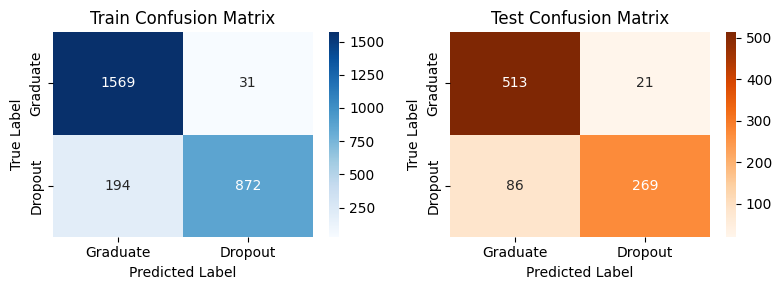


 -------------------------------------------------- 



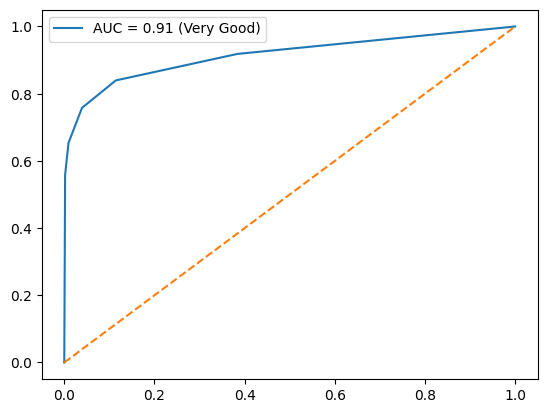

In [175]:
generateComparisonReport(model_knn, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(model_knn, X_test, y_test)

Strength:
- High Overall Performance: The model achieves a strong AUC of 0.91, indicating excellent discrimination between classes.
- Good Recall for Graduates: The recall for graduates (95.69%) is high, meaning most graduates are correctly identified.
- Balanced Precision & F1-Score: Both precision and F1-score are strong, indicating a well-performing model in both classes, however these are not our main metrics.
- Not overfitting: Train-Test Recall Gap: The recall difference between training and test data is small (~2-7%).

Weaknesses:
- Lower Recall for Dropouts: The model struggles slightly with identifying dropouts, leading to more false negatives (misclassified as graduates).
- Misclassification in Test Set: 87 dropouts are wrongly predicted as graduates, which may have practical consequences if early intervention is required.

#### SVM


TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,89.38%,97.75%,93.38%,534.0,0.69%
Dropout,96.07%,82.54%,88.79%,355.0,4.98%



 -------------------------------------------------- 



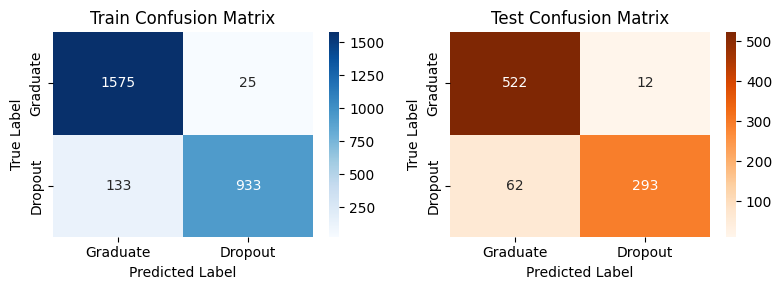


 -------------------------------------------------- 



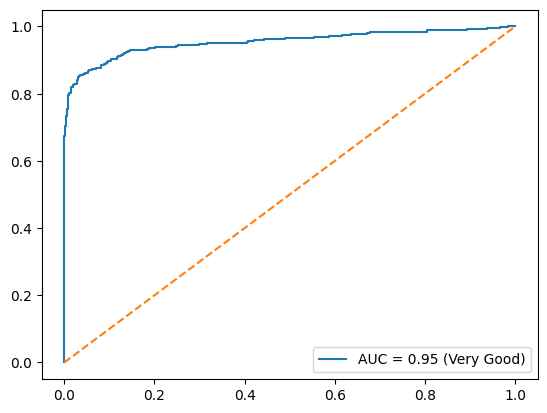

In [176]:
generateComparisonReport(model_svm, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(model_svm, X_test, y_test)

Strength:
- Higher AUC (0.95 vs. 0.91) → The model has better discriminatory power.
- Better Dropout Recall (82% vs. 75%) → Fewer false negatives for dropouts.
- Lower Train-Test Recall Gap → Less overfitting compared to the KNN.
- Higher Precision for Both Classes → Fewer false positives, better reliability.

Weakness:
- Dropout Recall Still Lower Than Graduate Recall, which is our main target

#### Decision Tree


TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,87.99%,87.83%,87.91%,534.0,12.17%
Dropout,81.74%,81.97%,81.86%,355.0,18.03%



 -------------------------------------------------- 



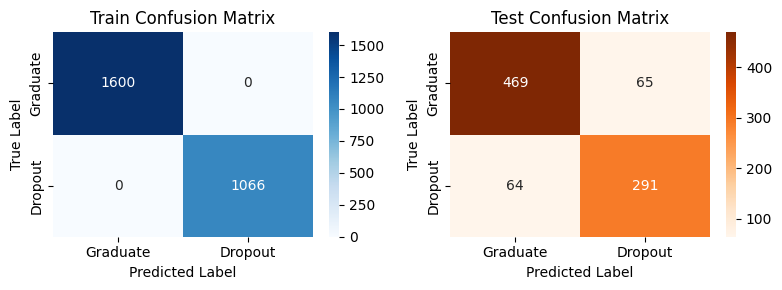


 -------------------------------------------------- 



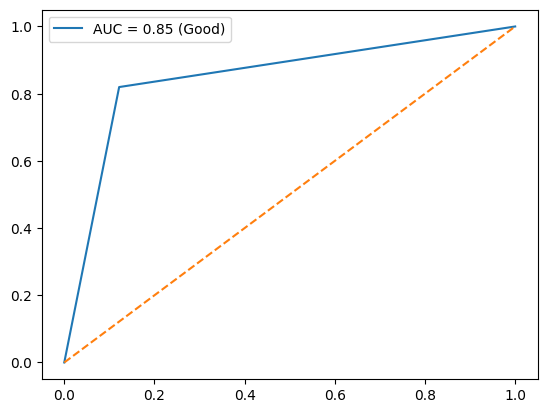

In [177]:
generateComparisonReport(model_dtree, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(model_dtree, X_test, y_test)

Strengths:
- Balanced Recall → Good identification of both classes.

Weaknesses:
- Overfitting: perfect classification in training data due to max depth not set (default setting), indicating poor generalization.
- Lower AUC compared to previous model → Weaker discriminative ability compared to the SVM or KNN.
- More False Positives in Test Set: some graduates were misclassified as dropouts.

#### Random Forest


TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,89.58%,96.63%,92.97%,534.0,3.37%
Dropout,94.25%,83.1%,88.32%,355.0,16.9%



 -------------------------------------------------- 



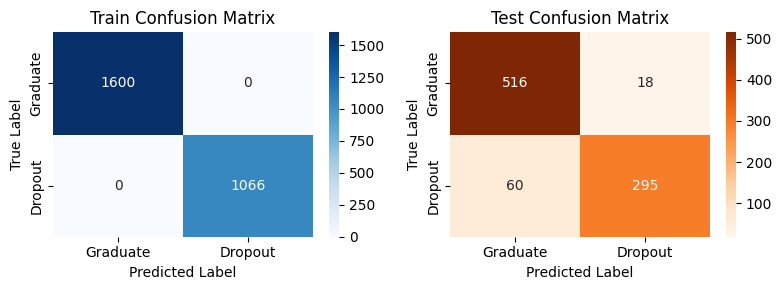


 -------------------------------------------------- 



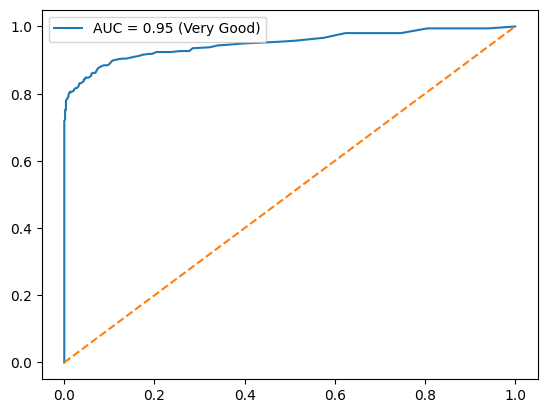

In [178]:
generateComparisonReport(model_rf, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(model_rf, X_test, y_test)

Strengths:
- High AUC (0.95) → Excellent model discrimination between graduate and dropout.
- Strong Graduate Recall → Captures almost all graduates accurately.
- Improved Precision for Dropouts → Fewer false positives compared to prior models, although not our main metric.
- Balanced F1-Scores → Well-rounded performance, although not our main metric.
- Reduced Overfitting for Graduates class: Train-test recall gap is smaller for graduates (3%), meaning better generalization.
- Overfitting is less compared to Decision Tree model

Weaknesses:
- Very High Overfitting Still Present in Dropout class, also likely due to default setting of max_depth = `None` 
- Dropout Recall still lower than graduate recall → The model still struggles more with identifying dropouts, most likely due to class imbalance.

#### CatBoost


TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,89.31%,97.0%,93.0%,534.0,2.88%
Dropout,94.82%,82.54%,88.25%,355.0,10.8%



 -------------------------------------------------- 



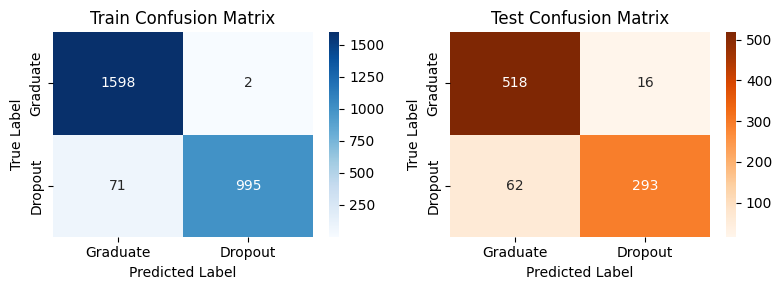


 -------------------------------------------------- 



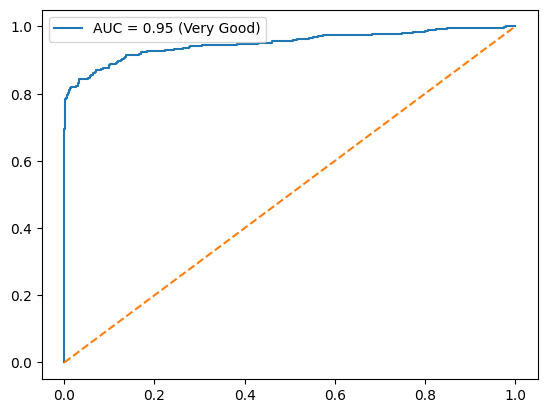

In [179]:
generateComparisonReport(model_cb, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(model_cb, X_test, y_test)

Strengths:
- High AUC (0.95) → Excellent discriminatory power.
- F1-scores are high for both classes (93.36% for graduates, 88.86% for dropouts), although this is not our main metric.
- Less Overfitting than Random Forest: Train-Test Recall Gap (2.31% for graduates, 10.05% for dropouts) are smaller than the previous Random Forest model with default setting.
- Lower False Positives & False Negatives: Fewer misclassifications in the test set (14 graduates misclassified as dropouts, 60 dropouts misclassified as graduates).
- Better dropout precision (95.47%), meaning fewer false alarms.

Weaknesses:
- Dropout Recall (83.1%) Still Lower Than Graduate Recall (97.38%) → Model still struggles with detecting dropouts. Mostly due to class imbalance.
- Slight overfitting: train-Test Gap for Dropouts 10.05% → The model still learns too much from the training set and not able to generalize very well.
- Slightly Higher False Negatives for Dropouts (60 dropouts misclassified as graduates in test set) → Might be a concern if early dropout detection is critical.

#### Cross Validation

In [180]:
def cross_validate_models(model_names, models, scoring_metrics):
    model_names_cv = {name: models[i] for i, name in enumerate(model_names)}

    results = []
    best_score = 0
    best_model = ''

    smallest_fit_delta = 0
    best_fitted_model = ''

    for name, model in model_names_cv.items():
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        cv_train = cross_val_score(model, X_train, y_train, scoring=scoring_metrics, n_jobs=-1, cv=skf)
        cv_test = cross_val_score(model, X_test, y_test, scoring=scoring_metrics, n_jobs=-1, cv=skf)

        train_mean = cv_train.mean()
        train_std = cv_train.std()
        test_mean = cv_test.mean()
        test_std = cv_test.std()
        train_test_diff = 0

        for index, score in enumerate(cv_train):
          train_test_diff = (train_test_diff + (score - cv_test[index])) / (index + 1)

        results.append({
            "Model": name,
            "Train Recall Mean": round(train_mean, 4),
            "Train Recall Range": f"{round(train_mean - train_std, 4)} - {round(train_mean + train_std, 4)}",
            "Test Recall Mean": round(test_mean, 4),
            "Test Recall Range": f"{round(test_mean - test_std, 4)} - {round(test_mean + test_std, 4)}",
            "Average Score Variance": (((train_mean + train_std) - (train_mean - train_std)) + ((test_mean + test_std) - (test_mean - test_std)))/2,
            "Train-Test Diff": round(train_test_diff, 4),
        })

        # Identify the best model
        if test_mean > best_score:
            best_score = test_mean
            best_model = name

        # Identify the best fit
        if best_fitted_model == '':
            smallest_fit_delta = train_test_diff
            best_fitted_model = name
        if train_test_diff < smallest_fit_delta:
            smallest_fit_delta = train_test_diff
            best_fitted_model = name

    # Create DataFrame
    df_results = pd.DataFrame(results)

    # Print recall score
    print('Best Model:', best_model.upper())
    print(f'Avg Test Recall from Best Model: {best_score:.4f}')

    return df_results

In [181]:
scoring_metrics = 'recall'
cross_validate_models(model_names, models, 'recall')

Best Model: CATBOOST
Avg Test Recall from Best Model: 0.8338


,Model,Train Recall Mean,Train Recall Range,Test Recall Mean,Test Recall Range,Average Score Variance,Train-Test Diff
0,KNN,0.7467,0.7104 - 0.7831,0.6986,0.627 - 0.7702,0.107955,0.0341
1,SVM,0.8415,0.8152 - 0.8677,0.8141,0.7658 - 0.8624,0.074560,0.0197
2,DecisionTree,0.8574,0.8373 - 0.8776,0.8085,0.7625 - 0.8544,0.066089,0.0263
3,RandomForest,0.8358,0.8097 - 0.862,0.8310,0.7989 - 0.8631,0.058254,0.0049
4,CatBoost,0.8574,0.8321 - 0.8827,0.8338,0.7946 - 0.873,0.064546,0.0145


1. Best Overall Model: CatBoost
    - Highest Train Recall Mean & Test Recall Mean, indicates strong learning and generalization.
    - Low Train-Test Difference (0.0145): Low overfitting.
    - Good Consistency: Reliable performance across folds.

2. Random Forest Performs Well, Slightly Below CatBoost
    - Test Recall (0.8310) is very close to CatBoost.
    - Lowest Train-Test Difference (0.0049) → Best generalization.
    - Slightly lower Train Recall vs. CatBoost.
    - Good consistency

3. Decision Tree Has Higher Train Recall but Overfits
    - Train Recall > Test Recall → Overfitting is present.
    - Higher Train-Test Difference compared to Random Forest & CatBoost.
    - Good consistency

4. SVM is Balanced but Slightly Weaker
    - Train Recall & Test Recall are solid but not the best
    - Small Train-Test Difference, but not the best
    - Average variance slightly higher (model is less consistent)

5. KNN is the Worst Performer
    - Lowest Train Recall & Test Recall.
    - Overfitting: Highest Train-Test Difference: Overfitting.
    - Worst Consistency: Highly unstable across folds.

- CatBoost is the best model with strong recall, low overfitting, and good consistency.
- Random Forest is very close in performance with even lower overfitting.
- SVM and Decision Tree are decent but less consistent.
- KNN is the worst model, underperforming in both recall and stability.

Based on the cross-validation result, we will pick `CatBoost` as our best model to be further tuned.

# Best Model Optimization

Pre-Tuned Scores of CatBoost:

In [182]:
# Get predictions for both training and test data
y_pred_train_cb = model_cb.predict(X_train)
y_pred_test_cb = model_cb.predict(X_test)

pretuned_train_cb = recall_score(y_train, y_pred_train_cb)
pretuned_test_cb = recall_score(y_test, y_pred_test_cb)

print('Recall Score - Train Set CB : ', round(pretuned_train_cb, 4))
print('Recall Score - Test Set CB : ', round(pretuned_test_cb, 4))

Recall Score - Train Set CB :  0.9334
Recall Score - Test Set CB :  0.8254


## Hyperparameter Tuning

In [183]:
##Parameter Tuning
param_cb = {
    'classifier__iterations': [100, 500],
    'classifier__depth': [4, 6, 8, 10],
    'classifier__auto_class_weights': ['Balanced'],
    'classifier__l2_leaf_reg': [5, 20]
}

# set up GridSearchCV
grid_search_cb = GridSearchCV(model_cb,
                               param_grid=param_cb,
                               scoring='recall',
                               cv=3,
                               verbose=2,
                               n_jobs=-1)

# fit
grid_search_cb.fit(X_train, y_train)

print('Best hyperparameters for CatBoost:', grid_search_cb.best_params_)
print('Best recall for CatBoost:', grid_search_cb.best_score_)

best_cb_model = grid_search_cb.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best hyperparameters for CatBoost: {'classifier__auto_class_weights': 'Balanced', 'classifier__depth': 4, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 20}
Best recall for CatBoost: 0.8677137732763623


## Post-Optimization Evaluation

In [184]:
y_pred_train_tuned_cb = best_cb_model.predict(X_train)
y_pred_test_tuned_cb = best_cb_model.predict(X_test)

posttuned_train_cb = recall_score(y_train, y_pred_train_tuned_cb)
posttuned_test_cb = recall_score(y_test, y_pred_test_tuned_cb)

tuning_comparison_cb = {
    'Model': ['Pre-Tuning', 'Post-Tuning'],
    'Recall Score - Train Set': [pretuned_train_cb, posttuned_train_cb],
    'Recall Score - Test Set': [pretuned_test_cb, posttuned_test_cb]
}

tuning_comparison_cb_df = pd.DataFrame(tuning_comparison_cb)
tuning_comparison_cb_df

,Model,Recall Score - Train Set,Recall Score - Test Set
0,Pre-Tuning,0.933396,0.825352
1,Post-Tuning,0.897749,0.845070


From hyperparameter tuning with 2 folds, the best recall score for dropout class it at 0.87, while re-training our model using the best parameters from Grid CV resulted in slighly higher test recall score (0.84), a better fit (reduced overfitting). We will use this model for our inference.

In [185]:
best_model = best_cb_model

In [186]:
cross_validate_models(['CatBoost (Pre-Tuned)', 'CatBoost (Post-Tuned)'], [model_cb, best_model], 'recall')

Best Model: CATBOOST (POST-TUNED)
Avg Test Recall from Best Model: 0.8592


,Model,Train Recall Mean,Train Recall Range,Test Recall Mean,Test Recall Range,Average Score Variance,Train-Test Diff
0,CatBoost (Pre-Tuned),0.8574,0.8321 - 0.8827,0.8338,0.7946 - 0.873,0.064546,0.0145
1,CatBoost (Post-Tuned),0.8658,0.843 - 0.8886,0.8592,0.831 - 0.8873,0.050961,0.0063



TEST CLASSIFICATION REPORT


,precision,recall,f1-score,support,train-test (recall)
Graduate,90.28%,95.69%,92.91%,534.0,1.19%
Dropout,92.88%,84.51%,88.5%,355.0,5.26%



 -------------------------------------------------- 



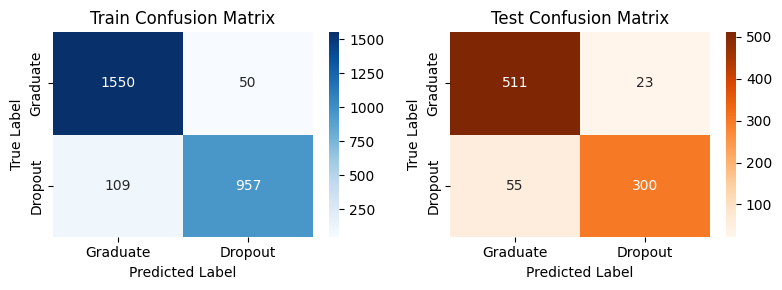


 -------------------------------------------------- 



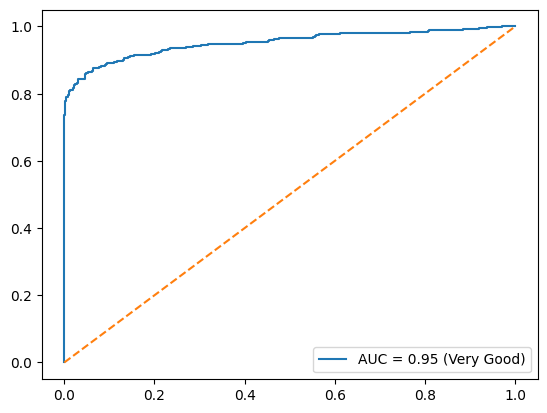

In [187]:
generateComparisonReport(best_model, X_train, y_train, X_test, y_test, True)
calculateAndPlotAUC(best_model, X_test, y_test)

In [191]:
# Create a DataFrame for error analysis
test_results = X_test.copy()
test_results['true_label'] = y_test
test_results['predicted_label'] = y_pred_test_tuned_cb
test_results['is_correct'] = test_results['true_label'] == test_results['predicted_label']

# Show misclassified samples
misclassified = test_results[~test_results['is_correct']]
print("Number of misclassified samples:", len(misclassified))
display(misclassified.head())


Number of misclassified samples: 78


,marital_status,application_order,course,course_time,education_level,admission_grade,is_displaced,is_debtor,is_tuition_paid,gender,...,s1_grade,s2_credited,s2_evaluated,s2_approved,s2_grade,s2_not_evaluated,gdp,true_label,predicted_label,is_correct
1778,single,1,Management,daytime,Secondary,49.00,1,0,1,male,...,57.00,0,7,4,55.000000,0,2.02,0,1,False
1166,married,2,Management,daytime,Higher education (diploma),51.70,0,0,1,female,...,58.75,3,12,7,55.714286,0,-1.70,1,0,False
3734,single,1,Management,daytime,Secondary,56.00,0,0,1,male,...,56.00,5,14,7,56.250000,2,-1.70,1,0,False
1630,married,1,Equinculture,daytime,Basic 3rd cycle (9th-11th),60.00,0,0,1,male,...,61.25,0,8,4,58.750000,0,-3.12,0,1,False
2855,single,1,Nursing,daytime,Secondary,63.95,1,0,1,female,...,67.30,0,8,7,61.187500,0,2.02,1,0,False


In [ ]:
misclassified.to_csv('./data/misclassified_samples.csv', index=False)

***Improvements After Tuning:***

- Better Balance Between Classes: Dropout Recall Improved compared to previous models.
- Graduate Recall remains high while reducing overfitting.
- F1-scores remain strong.
- Lower Overfitting: Train-Test Recall Gap is now smaller, which is a great improvement from the previous pre-tuned model. This indicates the model is more generalizable compared to earlier versions.
- Fewer Misclassifications in Test Set.
- AUC Remains High (0.95): Model retains excellent discriminative power. No loss in overall performance while improving generalization.

***Areas for Improvement:***
- Dropout Recall still moderately high. We can still improve this further, preferably through more relevant dataset of `Dropout` class, given that our dataset is quite imbalanced.
- Tweak feature engineering, perhaps we have removed some highly relevant feature, or retain some features with high multicollinearity or low importance
- Further Hyperparameter Tuning Possible: Some additional refinements might further improve recall without sacrificing precision.

## Evaluate Coefficient

In [209]:
best_model_classifier = best_cb_model.named_steps['classifier']
feature_names = best_cb_model.named_steps['preprocessor'].named_transformers_['categorical_pipeline'].named_steps['encoder'].get_feature_names_out(input_features=categorical_columns)

all_feature_names = (
    list(numerical_columns) +
    list(feature_names) +
    list(binary_columns)
)

importances = best_model_classifier.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 10 most important features =============")
display(feature_importance_df.head(15))
print('-'*50,'\n')
print("Top 10 least important features =============")
display(feature_importance_df.tail(15))

len(feature_importance_df)

Top 10 most important features =============


,Feature,Importance
6,s2_approved,58.056518
34,is_tuition_paid,7.647148
7,s2_grade,6.440061
3,s1_grade,2.976736
1,admission_grade,2.458692
2,age_at_enrollment,2.421951
5,s2_evaluated,2.363599
35,is_scholarship_holder,2.252839
4,s2_credited,2.232019
16,course_Basic Education,1.759144


-------------------------------------------------- 

Top 10 least important features =============


,Feature,Importance
13,marital_status_single,0.298899
32,is_displaced,0.231700
20,course_Nursing,0.184523
15,course_Agronomy,0.181344
12,marital_status_married,0.115939
25,course_time_evening,0.112427
30,education_level_Secondary - not completed,0.051446
17,course_Communication Design,0.039533
26,education_level_Diploma,0.020082
10,marital_status_facto union,0.018516


36

The top 5 most important variables affecting a student's dropout risk are:
- Number of approved (passed) in semester 2
- Semester 1 & Semester 2 grades
- Financial ability to pay tuition

This suggest strongly that the key factors determining a student's risk to dropout are related mostly to academic aptitude (grades), and financial situation

# Model Saving

In [189]:
top_10_courses = list(top_10_courses)
reverse_mapping = {v: k for k, v in target_mapping.items()}

# Save the best model
with open('best_model.pkl', 'wb') as best_model_file:
  dill.dump(best_model, best_model_file)
   
# Save other reference files
with open ("reverse_mapping.txt", "w") as reverse_mapping_file:
    json.dump(reverse_mapping, reverse_mapping_file)

# Model Inference

Please see [P1M2_galuh_alifani_inf.ipynb](P1M2_galuh_alifani_inf.ipynb)

# Conceptual Problems

## Bagging
Explain the background of bagging and how bagging works.

Bagging was created to make models more stable and accurate, especially due to overfitting (learning too much from training data), making it struggle with new data (not able to generalize well). Bagging helps prevent this problem.

How bagging works:
1. Create Random Samples: It takes multiple random pieces of the original dataset.
2. Train Multiple Models: Each random piece is used to train a separate model
3. Predict the result based on majority vote (for classification) or from average of all models' predictions (for regressive/numerical predictions)
4. Bagging reduces mistakes by averaging multiple models, so if one model is wrong, others can balance it out.

Random Forest is one of the most popular bagging-based algorithms.



## Random Forest vs Boosting Algorithm

Explain the difference in how the Random Forest algorithm works with the boosting algorithm you chose.

The boosting algorithm that I chose is `CatBoost`.

- Random Forest is a bagging algorithm, which, as explained in the previous question, train multiple models (make many trees at the same time) and predict result based on majority votes (or combine results). Due to the parallel training, RF typically trains models more quickly, and can handle large datasets better compared to other models.

- CatBoost is a boosting algorithm, which, instead making many trees at the same time, it builds trees one after another, learning from past mistakes. It trains trees sequentially instead of in parallel. This is why typically training a CatBoost model takes longer time compared to bagging algorithm like Random Forest, because it does not build trees simultaneously, but can produce bette accuracy. CatBoost is also especially great with high-categorical dataset.

## Cross Validation

Explain what is meant by Cross Validation

Cross Validation is a method to *validate* a specific models' performance by splitting the train set into several folds, and re-training/re-testing the model several times using those data subsets. By doing cross-validation, we will know whether our model consistently perform well (or not), or whether that high score was just a 'lucky' one-time prediction.

Cross-validation makes sure the model works well on different types of data, helps prevent overfitting (learning too much from training data), and gives a more reliable performance score.

# Conclusion

We have succesfully developed a machine learning model to predict whether a student is likely to Dropout, with >80% recall rate and 95% AUC score, which means that the model is able to distinguish well the parameters of those who are likely to Dropout vs those who are likely to Graduate. 

However, due to our goal to be able to prevent student from dropping out and provide indivdual - early intervention actions, we will need to further increase the recall rate of this model, in order to better capture more students who are actually likely to drop out. With this model, we are still not capturing ~15% of students who actually will dropout.
While the model performs well, certain limitations such as data imbalance, feature selection, and generalizability should be considered for future improvements. 

Further refinements includes training additional real-world datasets for the target class (Dropout), along with more advanced modeling techniques and more refined feature engineering, such as feature extraction, and more granular and selective feature selection.

The intervention strategy that academic staff needs to develop for those who are likely to drop out, will need to be ***tailored*** and individually adjusted based on the individual itself, and based on which parameter is likely to contribute the most to his/her likelihood to drop out. Based on key findings from the analysis and model, it is suggested that the factors that significantly influence a student's likelihood of dropping out are ***academic grades, number of modules passed, and financial conditions***, hence, intervention strategies will most likely hover around these areas, some examples include:

- Offering financial aid (loan, scholarship) for students with financial hardship
- Offering chances for part-time work in lieu of studying to cover for school fees
- Offering personalized tutoring for a specific subject/module that the student is struggling with
- Mentorship program with model student or academic staff to better select modules in order to increase number of modules passed (approved)